In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tqdm
from scipy.special import logsumexp
import emcee
import dynesty
import jax
import jax.numpy as jnp
import jaxopt
import corner
import pandas as pd

In [2]:
def plot_data(x, y, x_err=None, y_err=None, params={}):
    """Plot data set with optional error bars and customizable formatting."""
    fig, ax = plt.subplots(1, 1, figsize=params.get('figsize', (8, 5)))
    ax.errorbar(x, y, xerr=x_err, yerr=y_err, 
                fmt=params.get('fmt', '.'), 
                color=params.get('color', 'royalblue'), 
                label=params.get('label', 'Data'), 
                ecolor=params.get('ecolor', 'gray'), 
                capsize=params.get('capsize', 1.5), alpha=0.9)
    ax.set_xlabel(params.get('xlabel', '$x$'), color='black', fontdict={'size':16})
    ax.set_ylabel(params.get('ylabel', '$y$'), color='black', fontdict={'size': 16})
    ax.set_xscale(params.get('xscale', 'linear'))
    ax.set_yscale(params.get('yscale', 'linear'))
    ax.set_title(params.get('title', ''), color='black')
    ax.grid(params.get('grid', True))
    ax.legend(frameon=params.get('legend_frame', False), loc=params.get('legend_loc', "upper left"))

    if 'xlim' in params:
        ax.set_xlim(params['xlim'])
    if 'ylim' in params:
        ax.set_ylim(params['ylim'])
    
    return fig, ax

In [3]:
def analyze_data_0(df, log_posterior, model, predict, x0):
    
    #Evaluate the data
    m, r, m_up, m_low, r_up, r_low = jnp.array(df['m']), jnp.array(df['r']), jnp.array(df['m+']), jnp.array(df['m-']), jnp.array(df['r+']), jnp.array(df['r-'])
    m_err=jnp.concatenate((jnp.atleast_2d(m_low),jnp.atleast_2d(m_up)))
    r_err=jnp.concatenate((jnp.atleast_2d(r_low),jnp.atleast_2d(r_up)))
    sigma_y=(r_up+r_low)/2
    sigma_x=(m_up+m_low)/2
    n = len(m)
    
    theta_init = jnp.array(x0)

    #Sample the posterior with emcee
    n_param = 2    
    n_walker = 6     
    n_step = 32000   
    
    seed = 1701
    num_steps = 100
    key = jax.random.key(seed)
    for i in range(num_steps):
        key, subkey = jax.random.split(key)

    theta_init = jnp.array(x0) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, 
        ndim=n_param, 
        log_prob_fn=log_posterior,
        args=(m, sigma_y, r)
    )
    
    state = sampler.run_mcmc(theta_init, nsteps=n_step)

    print("Auto-correlation time:")
    m_acl, b_acl = sampler.get_autocorr_time(quiet=True)
    
    print("m:", m_acl)
    print("b:", b_acl)

    acl = [m_acl, b_acl]
        
    theta_init = jnp.array(theta_init) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    disregard = 1000
    
    chain = sampler.get_chain(discard=disregard, thin=int(max(acl)/2), flat=True)

    logs = sampler.get_log_prob(discard=disregard, thin=int(max(acl)/2), flat=True)
    a = np.argmax(logs)
    theta_MAP = chain[a,:]
    m1_MAP, b1_MAP = theta_MAP[:]
    
    print(m1_MAP)
    print(b1_MAP)
    x_plot = jnp.sort(m)
    x_plot_log = jnp.log10(x_plot)
    y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP)
   

    #Plot the MAP
    plot_params = {'xlabel': r"$\frac{M}{M_{\oplus}}$", 'ylabel': r"$\frac{R}{R_{\oplus}}$",
                'xscale': 'log', 'yscale': 'log'}
    fig, ax = plot_data(x=m, y=r, y_err=r_err, params=plot_params)
    plt.plot(x_plot, y_MAP, color='C1', label="MAP model")
    plt.title("Maximum a posteriori estimate")
    plt.legend()
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('one_breakpoint_MAP_model.png', dpi=300)
    plt.show()
    
    print("Posterior results (mean±std): ")
    print(f"m_1 = {jnp.mean(chain[:,0]):.4f} ± {jnp.std(chain[:,0]):.4f}")
    print(f"b_1 = {jnp.mean(chain[:,1]):.4f} ± {jnp.std(chain[:,1]):.4f}")
    
    
    # CORNER PLOT
    modes = []
    for i in range(chain.shape[1]):
        hist, bin_edges = np.histogram(chain[:, i], bins=40)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_bin_index = np.argmax(hist)
        mode_value = bin_centers[max_bin_index]
        modes.append(mode_value)
        
    kde = scipy.stats.gaussian_kde(chain.T)
    mode_nd = chain[np.argmax(kde(chain.T)), :]
    
    fig = plt.figure(figsize=(9,6.5))
    fig = corner.corner(chain,
                        bins=40,
                        labels=["$m$", "$b_1$"],
                        color="royalblue",
                        truths=mode_nd,
                        truth_color="C1",
                        levels=1-np.exp(-0.5*np.array([1, 2])**2),
                        quantiles=[0.025, 0.16, 0.84, 0.975],
                        fig=fig
                       );
    
    fig.get_axes()[0].plot([], [], c="royalblue", label="Samples from the posterior")
    fig.get_axes()[0].plot([], [], c="C1", label="MAP model")
    fig.get_axes()[0].legend(loc='upper right', bbox_to_anchor=(6, 1))
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(14)  # Adjust x-axis label size
        ax.yaxis.label.set_size(14)  # Adjust y-axis label size
        ax.tick_params(axis="both", which="major", labelsize=7)  # Adjust tick label size
    plt.savefig("one_breakpoint_corner_plot.png", dpi=300)
    plt.show()
    
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(sample, x_plot) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    
    # Get samples from the posterior predictive distribution
    posterior_predictive = np.array(
        [predict(*sample, x_plot_log, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Plot the Model predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(x_plot, y_MAP, label="MAP model", color="C1", alpha=0.9)
    ax.fill_between(x=x_plot, y1=model_quantiles[0], y2=model_quantiles[-1],
                    color="blue", alpha=0.3, label="Model predictive distribution")
    ax.fill_between(x=x_plot, y1=model_quantiles[1], y2=model_quantiles[-2],
                    color="blue", alpha=0.7)
    
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Model predictive distribution', color='black')
    ax.legend(frameon=False, loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    #plt.savefig('one_breakpoint_model_predictive.png', dpi=300)
    plt.show()
    plt.close()


    
    #Plot the Posterior predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[0], y2=posterior_predictive_quantiles[-1],
                 color="grey", alpha=0.3, label="Posterior predictive distribution")
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[1], y2=posterior_predictive_quantiles[-2],
                 color="grey", alpha=0.7)
    plt.plot(x_plot,y_MAP,label="MAP model", color="C1")
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size':16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Posterior predictive distribution', color='black')
    ax.grid(True)
    ax.legend(frameon=False, loc="upper left")
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('One_breakpoint_posterior_predictive.png', dpi=300)
    plt.show()

    # Generate the iteration steps
    x_iter = np.arange(start=disregard, stop= (disregard + len(chain)))
    # Create a figure with 6 subplots arranged in 2 columns
    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    params = ["$m$", "$b_1$"]
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.plot(x_iter, chain[:, i], color="teal", linewidth=1.5, alpha=0.8)
        ax.set_ylabel(params[i], fontsize=12)
        ax.grid(visible=True, linestyle="--", alpha=0.5)  # Add gridlines
        ax.tick_params(axis="both", which="major", labelsize=10)

    fig.supxlabel("Iteration step", fontsize=14)
    fig.suptitle("MCMC Chain Progression for Each Parameter", fontsize=16, y=0.93)

    fig.tight_layout(h_pad=2.0, w_pad=2.0)
    plt.subplots_adjust(top=0.9)
    #plt.savefig('one_breakpoint_MCMC_chains.png', dpi=300)
    plt.show()
    
    return theta_MAP, chain, posterior_predictive

In [4]:
def model_0(theta, x):
    x_log=jnp.log10(x)
    m_1, b_1 = theta
    y=m_1+x_log*b_1
    return 10**y


def log_likelihood_0(theta, x, sigma_y, y):
    prediction = model_0(theta, x)
    prob = -0.5 * jnp.sum((y - prediction)**2/(sigma_y**2))  
    - 1/2*jnp.sum(jnp.log(2*jnp.pi*sigma_y**2))
    if jnp.isnan(prob): return -jnp.inf
    return (prob)

def posterior_probability_0(theta, x, sigma_y, y):
    return (
        log_likelihood_0(theta, x, sigma_y, y)
        + log_prior_0(theta))
    
def predict_0(m_1, b_1, x_log, sigma_y):
    mi = 10**(m_1+x_log*b_1)
    return np.random.normal(loc=mi, scale=sigma_y)

In [5]:
data_old = pd.read_csv("DACE_Exo.csv", delimiter=";", dayfirst=True, parse_dates=["last_updated"])

data_new = data_old[["planet_mass","planet_mass_lower","planet_mass_upper","planet_radius","planet_radius_lower","planet_radius_upper","discovery_year","last_updated"]]

df=data_new.dropna()
df['ts'] = df.last_updated.values.astype(np.int64) / (10 ** 9)

df.rename(columns={'planet_radius': 'r', 'planet_radius_upper': 'r+', 'planet_radius_lower':'r-',
                            'planet_mass':'m', 'planet_mass_upper':'m+', 'planet_mass_lower':'m-'}, inplace=True)

# Drop planets which were released after the paper came out:
df = df.drop(df[(df.ts >= 1688252923) & (df.discovery_year == 2023)].index)
df = df.drop(['ts', 'discovery_year', 'last_updated'], axis=1)# Drop relative error columns

#Change to Earth Masses and Radius
df['m'], df['m-'], df['m+'] = df['m']*317.8284, df['m-']*317.8, df['m+']*317.8
df['r'], df['r-'], df['r+'] = df['r']*11.2089, df['r-']*11.2089, df['r+']*11.2089

df = df.sort_values('m')

/tmp/ipykernel_688/3836521161.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_old = pd.read_csv("DACE_Exo.csv", delimiter=";", dayfirst=True, parse_dates=["last_updated"])


Auto-correlation time:
m: 26.101748203461938
b: 27.55284373136218
0.06853894889354706
0.3757025897502899


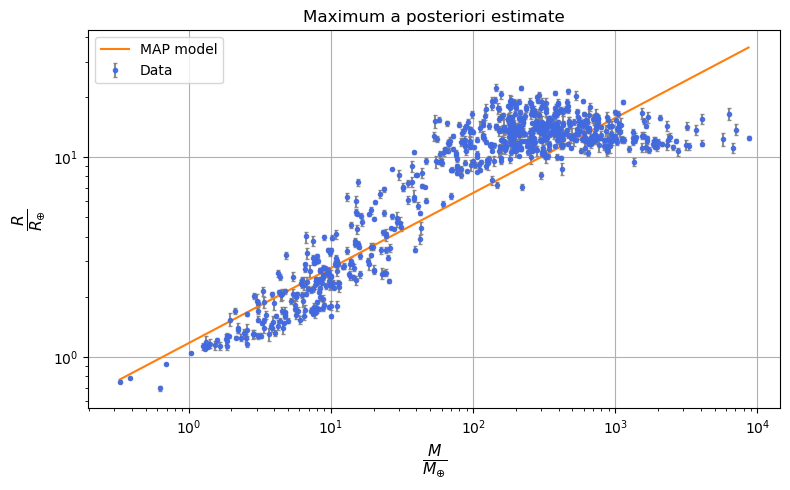

Posterior results (mean±std): 
m_1 = 0.0685 ± 0.0008
b_1 = 0.3757 ± 0.0004


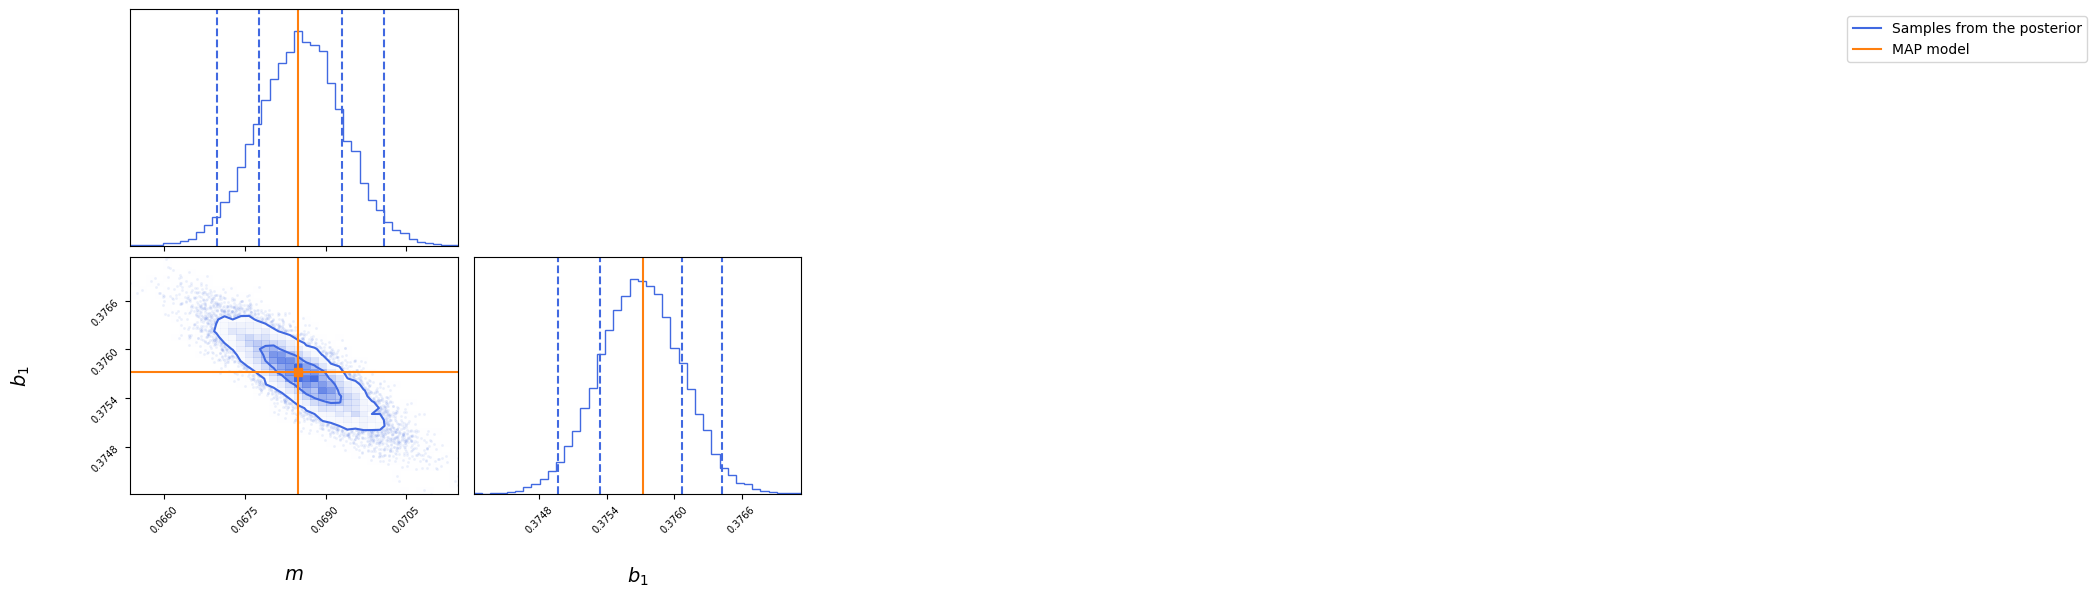

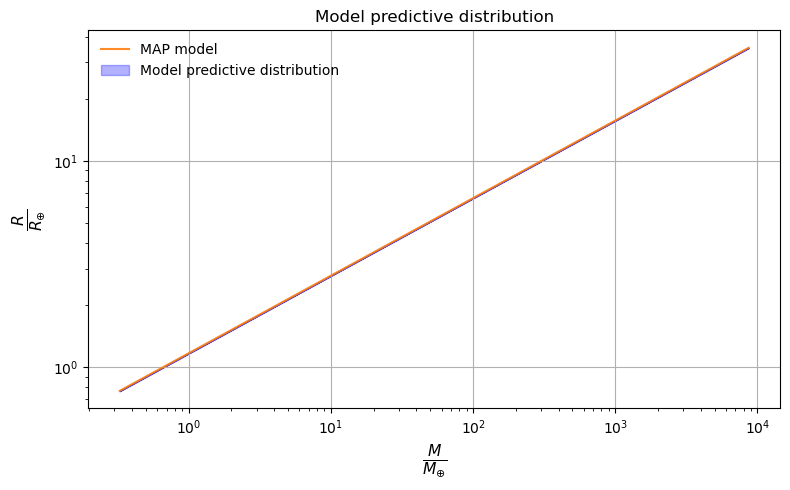

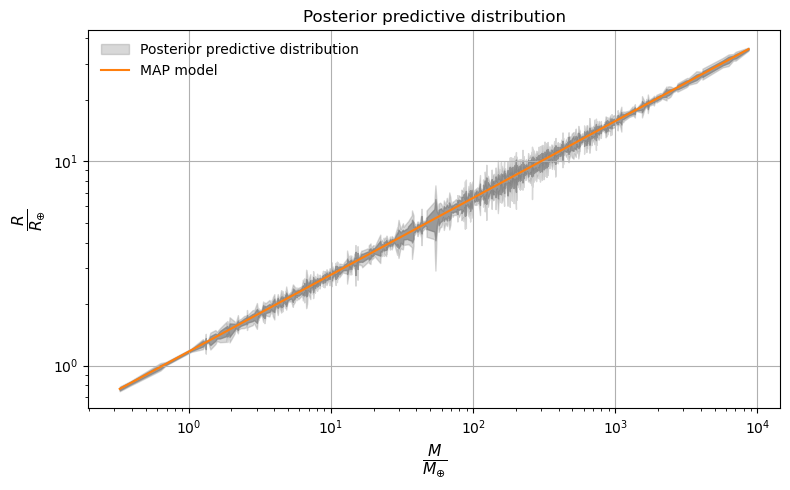

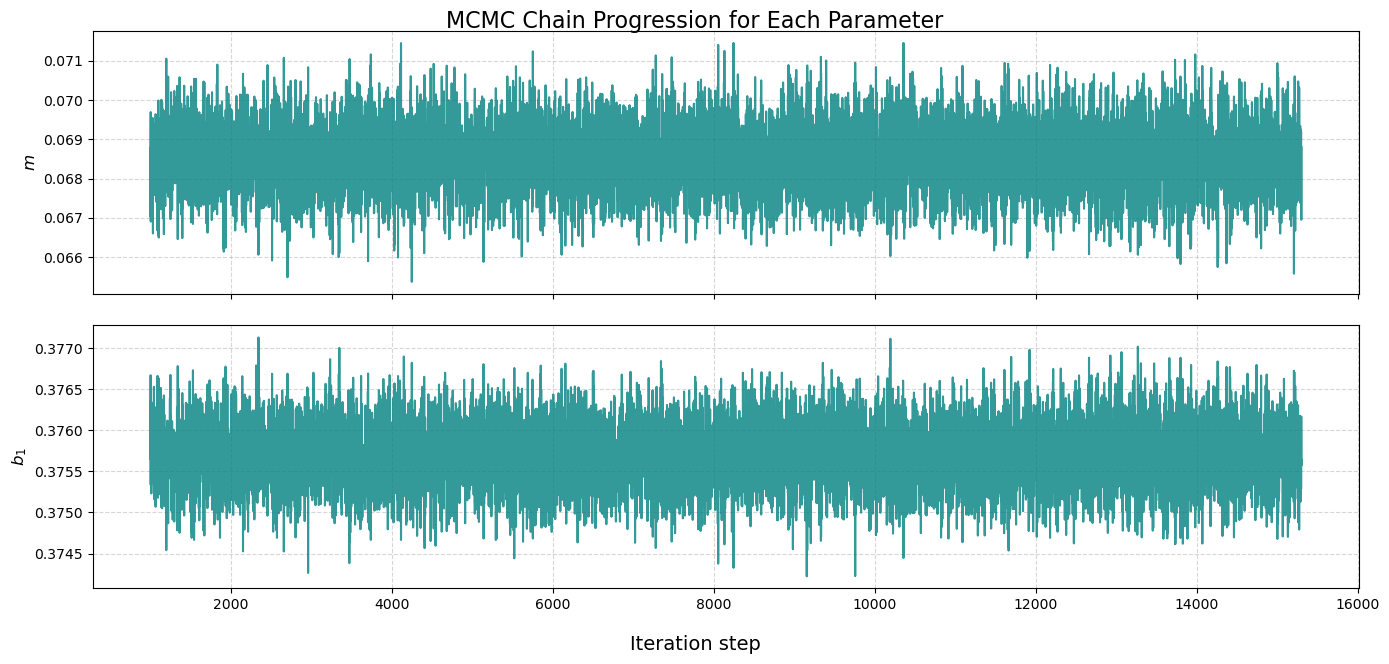

In [8]:
#Analysis for all planets with zero breakpoints

def log_prior_0(theta):
    m_1, b_1 =theta
    # Unnormalised uniform prior
    if -4 < m_1 < 4 and -2 < b_1 < 3:
        return 0.0
    else:
        return -jnp.inf

theta_MAP_0_breakpoints, chain_0, ppd_0 = analyze_data_0(
    df,
    log_posterior=posterior_probability_0,
    model=model_0,
    predict=predict_0, 
    x0=(0,0.4)
)

In [9]:
def analyze_data_1(df, log_posterior, model, predict, x0):
    
    #Evaluate the data
    m, r, m_up, m_low, r_up, r_low = jnp.array(df['m']), jnp.array(df['r']), jnp.array(df['m+']), jnp.array(df['m-']), jnp.array(df['r+']), jnp.array(df['r-'])
    m_err=jnp.concatenate((jnp.atleast_2d(m_low),jnp.atleast_2d(m_up)))
    r_err=jnp.concatenate((jnp.atleast_2d(r_low),jnp.atleast_2d(r_up)))
    sigma_y=(r_up+r_low)/2
    sigma_x=(m_up+m_low)/2
    n = len(m)
    
    theta_init = jnp.array(x0)

    #Sample the posterior with emcee
    n_param = 4    
    n_walker = 10     
    n_step = 32000   
    
    seed = 1701
    num_steps = 100
    key = jax.random.key(seed)
    for i in range(num_steps):
        key, subkey = jax.random.split(key)

    theta_init = jnp.array(x0) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, 
        ndim=n_param, 
        log_prob_fn=log_posterior,
        args=(m, sigma_y, r)
    )
    
    state = sampler.run_mcmc(theta_init, nsteps=n_step)

    print("Auto-correlation time:")
    m_acl, b1_acl, b2_acl, P_acl = sampler.get_autocorr_time(quiet=True)
    
    print("m:", m_acl)
    print("b1:", b1_acl)
    print("b2:", b2_acl)
    print("P1:", P_acl)

    acl = [m_acl, b1_acl, b2_acl, P_acl]
        
    theta_init = jnp.array(theta_init) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    disregard = 1000
    
    chain = sampler.get_chain(discard=disregard, thin=int(max(acl)/2), flat=True)

    logs = sampler.get_log_prob(discard=disregard, thin=int(max(acl)/2), flat=True)
    a = np.argmax(logs)
    theta_MAP = chain[a,:]
    m1_MAP, b1_MAP, b2_MAP, P_MAP = theta_MAP[:]
    
    x_plot = jnp.sort(m)
    x_plot_log = jnp.log10(x_plot)
    y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P_MAP), x_plot_log - jnp.log10(P_MAP), 0)*b2_MAP)
   

    #Plot the MAP
    plot_params = {'xlabel': r"$\frac{M}{M_{\oplus}}$", 'ylabel': r"$\frac{R}{R_{\oplus}}$",
                'xscale': 'log', 'yscale': 'log'}
    fig, ax = plot_data(x=m, y=r, y_err=r_err, params=plot_params)
    # Plot vertical line at P_MAP
    vline_color = 'mediumseagreen'
    plt.axvline(P_MAP, color=vline_color, linestyle='--')
    # Add annotations for the vertical line
    ax.annotate(rf"$P$ MAP: {P_MAP:.1f}", xy=(P_MAP, ax.get_ylim()[0]), 
                xytext=(50, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color)
    plt.plot(x_plot, y_MAP, color='C1', label="MAP model")
    plt.title("Maximum a posteriori estimate")
    plt.legend()
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('one_breakpoint_MAP_model.png', dpi=300)
    plt.show()
    
    print("Posterior results (mean±std): ")
    print(f"m_1 = {jnp.mean(chain[:,0]):.4f} ± {jnp.std(chain[:,0]):.4f}")
    print(f"b_1 = {jnp.mean(chain[:,1]):.4f} ± {jnp.std(chain[:,1]):.4f}")
    print(f"b_2 = {jnp.mean(chain[:,2]):.4f} ± {jnp.std(chain[:,2]):.4f}")
    print(f"P = {jnp.mean(chain[:,3]):.4f} ± {jnp.std(chain[:,3]):.4f}")
    
    
    # CORNER PLOT
    modes = []
    for i in range(chain.shape[1]):
        hist, bin_edges = np.histogram(chain[:, i], bins=40)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_bin_index = np.argmax(hist)
        mode_value = bin_centers[max_bin_index]
        modes.append(mode_value)
        
    kde = scipy.stats.gaussian_kde(chain.T)
    mode_nd = chain[np.argmax(kde(chain.T)), :]
    
    fig = plt.figure(figsize=(9,6.5))
    fig = corner.corner(chain,
                        bins=40,
                        labels=["$m$", "$b_1$", "$b_2$", "$P$"],
                        color="royalblue",
                        truths=mode_nd,
                        truth_color="C1",
                        levels=1-np.exp(-0.5*np.array([1, 2])**2),
                        quantiles=[0.025, 0.16, 0.84, 0.975],
                        fig=fig
                       );
    
    fig.get_axes()[0].plot([], [], c="royalblue", label="Samples from the posterior")
    fig.get_axes()[0].plot([], [], c="C1", label="MAP model")
    fig.get_axes()[0].legend(loc='upper right', bbox_to_anchor=(6, 1))
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(14)  # Adjust x-axis label size
        ax.yaxis.label.set_size(14)  # Adjust y-axis label size
        ax.tick_params(axis="both", which="major", labelsize=7)  # Adjust tick label size
    #plt.savefig("one_breakpoint_corner_plot.png", dpi=300)
    plt.show()
    
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(sample, x_plot) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    
    # Get samples from the posterior predictive distribution
    posterior_predictive = np.array(
        [predict(*sample, x_plot_log, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Plot the Model predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(x_plot, y_MAP, label="MAP model", color="C1", alpha=0.9)
    ax.fill_between(x=x_plot, y1=model_quantiles[0], y2=model_quantiles[-1],
                    color="blue", alpha=0.3, label="Model predictive distribution")
    ax.fill_between(x=x_plot, y1=model_quantiles[1], y2=model_quantiles[-2],
                    color="blue", alpha=0.7)
    vline_color = 'mediumseagreen'
    P_mean = jnp.mean(chain[:, 3])
    ax.axvline(P_mean, color=vline_color, linestyle='--')
    y_position = ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # Adjust y-position slightly above the bottom
    ax.annotate(f"$P$ = {P_mean:.2f}",
                xy=(P_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Model predictive distribution', color='black')
    ax.legend(frameon=False, loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    #plt.savefig('one_breakpoint_model_predictive.png', dpi=300)
    plt.show()
    plt.close()


    
    #Plot the Posterior predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[0], y2=posterior_predictive_quantiles[-1],
                 color="grey", alpha=0.3, label="Posterior predictive distribution")
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[1], y2=posterior_predictive_quantiles[-2],
                 color="grey", alpha=0.7)
    plt.plot(x_plot,y_MAP,label="MAP model", color="C1")
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size':16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Posterior predictive distribution', color='black')
    ax.grid(True)
    ax.legend(frameon=False, loc="upper left")
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('One_breakpoint_posterior_predictive.png', dpi=300)
    plt.show()

    # Generate the iteration steps
    x_iter = np.arange(start=disregard, stop= (disregard + len(chain)))
    # Create a figure with 6 subplots arranged in 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
    params = ["$m$", "$b_1$", "$b_2$", "$P$"]
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.plot(x_iter, chain[:, i], color="teal", linewidth=1.5, alpha=0.8)
        ax.set_ylabel(params[i], fontsize=12)
        ax.grid(visible=True, linestyle="--", alpha=0.5)  # Add gridlines
        ax.tick_params(axis="both", which="major", labelsize=10)

    fig.supxlabel("Iteration step", fontsize=14)
    fig.suptitle("MCMC Chain Progression for Each Parameter", fontsize=16, y=0.93)

    fig.tight_layout(h_pad=2.0, w_pad=2.0)
    plt.subplots_adjust(top=0.9)
    #plt.savefig('one_breakpoint_MCMC_chains.png', dpi=300)
    plt.show()
    
    return theta_MAP, chain, posterior_predictive

In [10]:
def model_1(theta, x):
    x_log=jnp.log10(x)
    m_1, b_1, b_2, P = theta
    y=m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P), x_log - jnp.log10(P), 0)*b_2
    return 10**y


def log_likelihood_1(theta, x, sigma_y, y):
    prediction = model_1(theta, x)
    prob = -0.5 * jnp.sum((y - prediction)**2/(sigma_y**2))  
    - 1/2*jnp.sum(jnp.log(2*jnp.pi*sigma_y**2))
    if jnp.isnan(prob): return -jnp.inf
    return (prob)

def posterior_probability_1(theta, x, sigma_y, y):
    return (
        log_likelihood_1(theta, x, sigma_y, y)
        + log_prior_1(theta))
    
def predict_1(m_1, b_1, b_2, P, x_log, sigma_y):
    mi = 10**(m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P), x_log - jnp.log10(P), 0)*b_2)
    return np.random.normal(loc=mi, scale=sigma_y)

Auto-correlation time:
m: 38.377746924737025
b1: 33.387496732357384
b2: 69.04902217465789
P1: 144.56900670020107


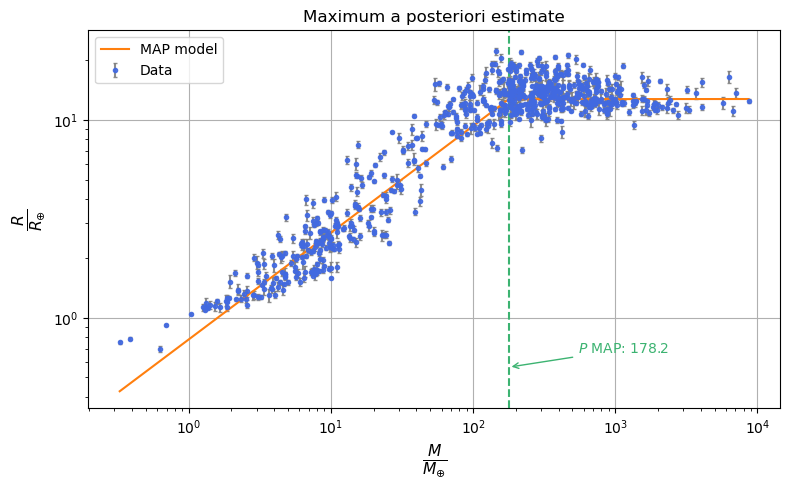

Posterior results (mean±std): 
m_1 = -0.1092 ± 0.0013
b_1 = 0.5396 ± 0.0009
b_2 = -0.5394 ± 0.0022
P = 178.3687 ± 0.9402


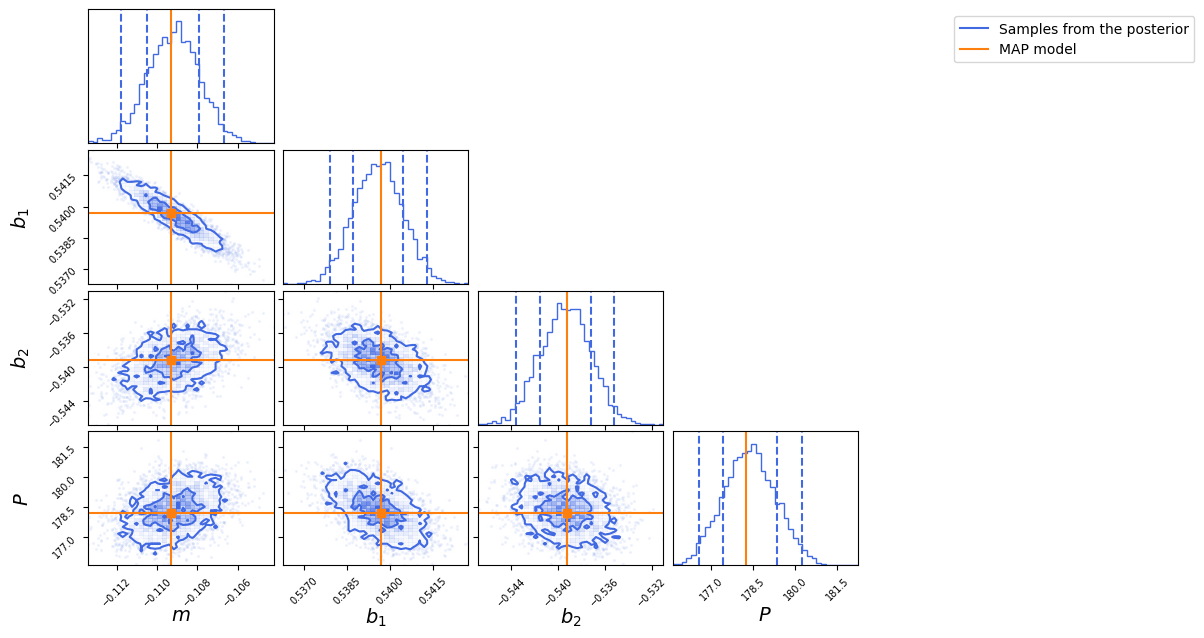

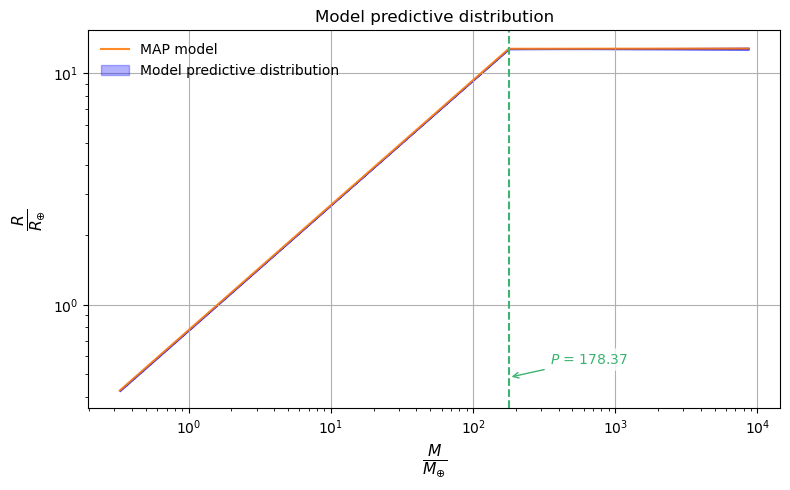

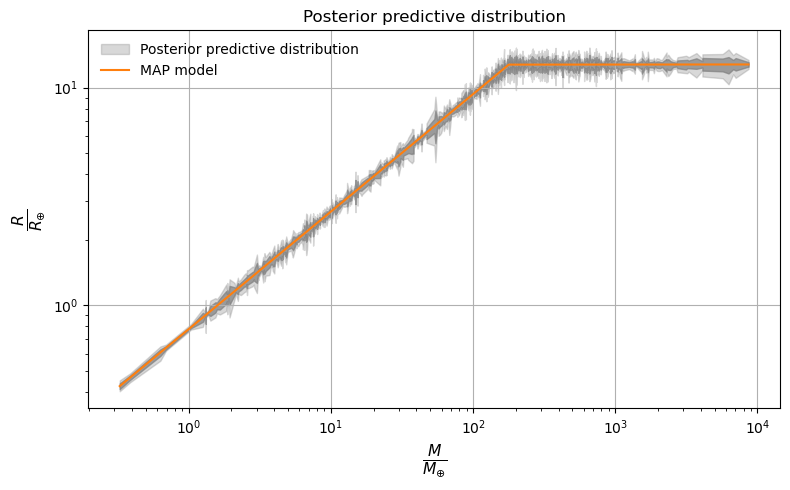

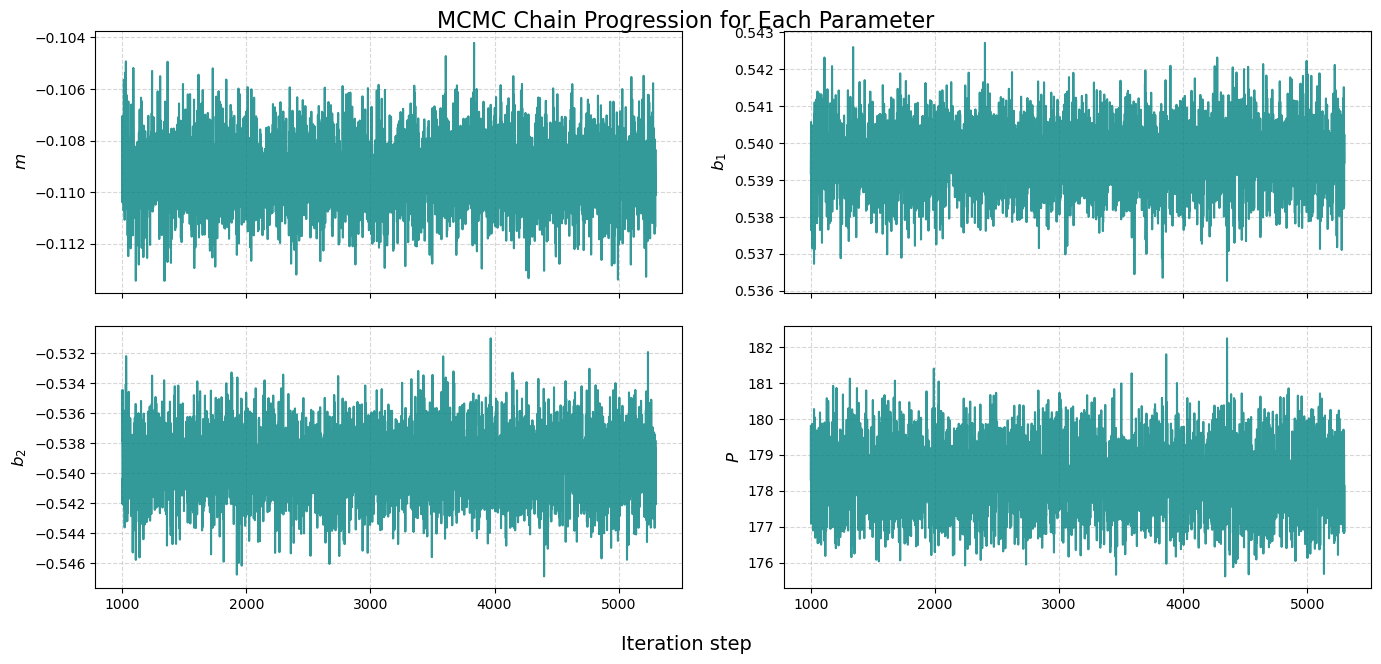

In [11]:
#Analysis for all planets with one breakpoint

def log_prior_1(theta):
    m_1, b_1, b_2, P =theta
    # Unnormalised uniform prior
    if -4 < m_1 < 4 and -2 < b_1 < 3 and -3 < b_2 < 3 and 5 < P < 300:
        return 0.0
    else:
        return -jnp.inf

theta_MAP_1_breakpoint, chain_1, ppd_1 = analyze_data_1(
    df,
    log_posterior=posterior_probability_1,
    model=model_1,
    predict=predict_1, 
    x0=(0,0.4,-0.4,170)
)


In [12]:
def analyze_data_2(df, log_posterior, model, predict, x0):
    
    #Evaluate the data
    m, r, m_up, m_low, r_up, r_low = jnp.array(df['m']), jnp.array(df['r']), jnp.array(df['m+']), jnp.array(df['m-']), jnp.array(df['r+']), jnp.array(df['r-'])
    m_err=jnp.concatenate((jnp.atleast_2d(m_low),jnp.atleast_2d(m_up)))
    r_err=jnp.concatenate((jnp.atleast_2d(r_low),jnp.atleast_2d(r_up)))
    sigma_y=(r_up+r_low)/2
    sigma_x=(m_up+m_low)/2
    n = len(m)
    
    theta_init = jnp.array(x0)

    #Sample the posterior with emcee
    n_param = 6    
    n_walker = 14     
    n_step = 32000   
    
    seed = 1701
    num_steps = 100
    key = jax.random.key(seed)
    for i in range(num_steps):
        key, subkey = jax.random.split(key)

    theta_init = jnp.array(x0) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, 
        ndim=n_param, 
        log_prob_fn=log_posterior,
        args=(m, sigma_y, r)
    )
    
    state = sampler.run_mcmc(theta_init, nsteps=n_step)

    print("Auto-correlation time:")
    m_acl, b1_acl, b2_acl, b3_acl, P1_acl, P2_acl = sampler.get_autocorr_time(quiet=True)
    
    print("m:", m_acl)
    print("b1:", b1_acl)
    print("b2:", b2_acl)
    print("b3:", b3_acl)
    print("P1:", P1_acl)
    print("P2:", P2_acl)

    acl = [m_acl, b1_acl, b2_acl, b3_acl, P1_acl, P2_acl]
        
    theta_init = jnp.array(theta_init) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    disregard = 1000
    
    chain = sampler.get_chain(discard=disregard, thin=int(max(acl)/2), flat=True)

    logs = sampler.get_log_prob(discard=disregard, thin=int(max(acl)/2), flat=True)
    a = np.argmax(logs)
    theta_MAP = chain[a,:]
    m1_MAP, b1_MAP, b2_MAP, b3_MAP, P1_MAP, P2_MAP = theta_MAP[:]

    print("MAP values:")

    print("m:", m1_MAP)
    print("b1:", b1_MAP)
    print("b2:", b2_MAP)
    print("b3:", b3_MAP)
    print("P1:", P1_MAP)
    print("P2:", P2_MAP)
    
    x_plot = jnp.sort(m)
    x_plot_log = jnp.log10(x_plot)
    y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP+jnp.where(x_plot_log > jnp.log10(P2_MAP), x_plot_log - jnp.log10(P2_MAP), 0)*b3_MAP)
   

    #Plot the MAP
    plot_params = {'xlabel': r"$\frac{M}{M_{\oplus}}$", 'ylabel': r"$\frac{R}{R_{\oplus}}$",
                'xscale': 'log', 'yscale': 'log'}
    fig, ax = plot_data(x=m, y=r, y_err=r_err, params=plot_params)
    # Plot vertical lines at P1_MAP and P2_MAP
    vline_color = 'mediumseagreen'
    plt.axvline(P1_MAP, color=vline_color, linestyle='--')
    plt.axvline(P2_MAP, color=vline_color, linestyle='--')
    # Add annotations for the vertical lines
    ax.annotate(rf"$P_1$ MAP: {P1_MAP:.1f}", xy=(P1_MAP, ax.get_ylim()[0]), 
                xytext=(50, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color)
    ax.annotate(rf"$P_2$ MAP: {P2_MAP:.1f}", xy=(P2_MAP, ax.get_ylim()[0]), 
                xytext=(50, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color)
    plt.plot(x_plot, y_MAP, color='C1', label="MAP model")
    plt.title("Maximum a posteriori estimate")
    plt.legend()
    fig.tight_layout(h_pad=2.0)
    plt.show()
    
    print("Posterior results (mean±std): ")
    print(f"m_1 = {jnp.mean(chain[:,0]):.4f} ± {jnp.std(chain[:,0]):.4f}")
    print(f"b_1 = {jnp.mean(chain[:,1]):.4f} ± {jnp.std(chain[:,1]):.4f}")
    print(f"b_2 = {jnp.mean(chain[:,2]):.4f} ± {jnp.std(chain[:,2]):.4f}")
    print(f"b_3 = {jnp.mean(chain[:,3]):.4f} ± {jnp.std(chain[:,3]):.4f}")
    print(f"P_1 = {jnp.mean(chain[:,4]):.4f} ± {jnp.std(chain[:,2]):.4f}")
    print(f"P_2 = {jnp.mean(chain[:,5]):.4f} ± {jnp.std(chain[:,3]):.4f}")
    
    
    # CORNER PLOT
    modes = []
    for i in range(chain.shape[1]):
        hist, bin_edges = np.histogram(chain[:, i], bins=40)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_bin_index = np.argmax(hist)
        mode_value = bin_centers[max_bin_index]
        modes.append(mode_value)
        
    kde = scipy.stats.gaussian_kde(chain.T)
    mode_nd = chain[np.argmax(kde(chain.T)), :]
    print("mode_nd:",mode_nd)
    
    fig = plt.figure(figsize=(9,6.5))
    fig = corner.corner(chain,
                        bins=40,
                        labels=["$m$", "$b_1$", "$b_2$", "$b_3$", "$P_1$", "$P_2$"],
                        color="royalblue",
                        truths=mode_nd,
                        truth_color="C1",
                        levels=1-np.exp(-0.5*np.array([1, 2])**2),
                        quantiles=[0.025, 0.16, 0.84, 0.975],
                        fig=fig
                       );
    
    fig.get_axes()[0].plot([], [], c="royalblue", label="Samples from the posterior")
    fig.get_axes()[0].plot([], [], c="C1", label="Posterior mode")
    fig.get_axes()[0].legend(loc='upper right', bbox_to_anchor=(6, 1))
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(14)  # Adjust x-axis label size
        ax.yaxis.label.set_size(14)  # Adjust y-axis label size
        ax.tick_params(axis="both", which="major", labelsize=7)  # Adjust tick label size
    plt.savefig('corner_new.png', dpi=300)
    plt.show()
    
    fig = plt.figure(figsize=(9,6.5))
    fig = corner.corner(chain,
                        bins=40,
                        labels=["$m$", "$b_1$", "$b_2$", "$b_3$", "$P_1$", "$P_2$"],
                        color="royalblue",
                        truths=theta_MAP,
                        truth_color="C1",
                        levels=1-np.exp(-0.5*np.array([1, 2])**2),
                        quantiles=[0.025, 0.16, 0.84, 0.975],
                        fig=fig
                       );
    
    fig.get_axes()[0].plot([], [], c="royalblue", label="Samples from the posterior")
    fig.get_axes()[0].plot([], [], c="C1", label="MAP model")
    fig.get_axes()[0].legend(loc='upper right', bbox_to_anchor=(6, 1))
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(14)  # Adjust x-axis label size
        ax.yaxis.label.set_size(14)  # Adjust y-axis label size
        ax.tick_params(axis="both", which="major", labelsize=7)  # Adjust tick label size
    plt.show()
    
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(sample, x_plot) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    
    # Get samples from the posterior predictive distribution
    posterior_predictive = np.array(
        [predict(*sample, x_plot_log, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Plot the Model predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(x_plot, y_MAP, label="MAP model", color="C1", alpha=0.9)
    ax.fill_between(x=x_plot, y1=model_quantiles[0], y2=model_quantiles[-1],
                    color="blue", alpha=0.3, label="Model predictive distribution")
    ax.fill_between(x=x_plot, y1=model_quantiles[1], y2=model_quantiles[-2],
                    color="blue", alpha=0.7)
    ax.errorbar(x=m, y=r, yerr=r_err, label="Data", fmt=".")
    vline_color = 'mediumseagreen'
    P1_mean = jnp.mean(chain[:, 4])
    P2_mean = jnp.mean(chain[:, 5])
    ax.axvline(P1_mean, color=vline_color, linestyle='--')
    ax.axvline(P2_mean, color=vline_color, linestyle='--')

    y_position = ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # Adjust y-position slightly above the bottom
    ax.annotate(f"$P_1$ = {P1_mean:.2f}",
                xy=(P1_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P_2$ = {P2_mean:.2f}",
                xy=(P2_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Model predictive distribution', color='black')
    ax.legend(frameon=False, loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    plt.savefig('mpd_new.png', dpi=300)
    plt.show()
    plt.close()


    
    #Plot the Posterior predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    ax.plot(x_plot,y_MAP,label="MAP model", color="C1")
    ax.errorbar(x=m, y=r, yerr=r_err,label="Data",fmt=".")
    ax.fill_between(x=x_plot, y1=posterior_predictive_quantiles[0], y2=posterior_predictive_quantiles[-1],
                 color="grey", alpha=0.3, label="Posterior predictive distribution")
    ax.fill_between(x=x_plot, y1=posterior_predictive_quantiles[1], y2=posterior_predictive_quantiles[-2],
                 color="grey", alpha=0.7)
    vline_color = 'mediumseagreen'
    P1_mean = jnp.mean(chain[:, 4])
    P2_mean = jnp.mean(chain[:, 5])
    ax.axvline(P1_mean, color=vline_color, linestyle='--')
    ax.axvline(P2_mean, color=vline_color, linestyle='--')

    y_position = ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # Adjust y-position slightly above the bottom
    ax.annotate(f"$P_1$ = {P1_mean:.2f}",
                xy=(P1_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P_2$ = {P2_mean:.2f}",
                xy=(P2_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size':16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Posterior predictive distribution', color='black')
    ax.grid(True)
    ax.legend(frameon=False, loc="upper left")
    fig.tight_layout(h_pad=2.0)
    plt.savefig('ppd_newnew.png', dpi=300)
    plt.show()

    chain_plot = sampler.get_chain(discard=0, thin=int(max(acl)/2), flat=True)
    # Generate the iteration steps
    x_iter = np.arange(start=0, stop=len(chain_plot))
    # Create a figure with 6 subplots arranged in 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(14, 7), sharex=True)
    params = ["$m$", "$b_1$", "$b_2$", "$b_3$", "$P_1$", "$P_2$"]
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.plot(x_iter, chain_plot[:, i], color="teal", linewidth=1.5, alpha=0.8)
        ax.set_ylabel(params[i], fontsize=12)
        ax.grid(visible=True, linestyle="--", alpha=0.5)  # Add gridlines
        ax.tick_params(axis="both", which="major", labelsize=10)

    fig.supxlabel("Iteration step", fontsize=14)
    fig.suptitle("MCMC Chain Progression for Each Parameter", fontsize=16, y=0.93)

    fig.tight_layout(h_pad=2.0, w_pad=2.0)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return theta_MAP, chain, posterior_predictive

In [13]:
def model_2(theta, x):
    x_log=jnp.log10(x)
    m_1, b_1, b_2, b_3, P_1, P_2 = theta
    y=m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P_1), x_log - jnp.log10(P_1), 0)*b_2+jnp.where(x_log > jnp.log10(P_2), x_log - jnp.log10(P_2), 0)*b_3
    return 10**y

#return jnp.log10(m_1)+jnp.where(x_log < jnp.log10(4.4), x_log, 0)*b_1+jnp.where((x_log > jnp.log10(4.4)) & (x_log < jnp.log10(127)), x_log, 0)*b_2+jnp.where(x_log > jnp.log10(127), x_log, 0)*b_3

def log_likelihood_2(theta, x, sigma_y, y):
    prediction = model_2(theta, x)
    prob = -0.5 * jnp.sum((y - prediction)**2/(sigma_y**2))  
    - 1/2*jnp.sum(jnp.log(2*jnp.pi*sigma_y**2))
    if jnp.isnan(prob): return -jnp.inf
    return (prob)

def posterior_probability_2(theta, x, sigma_y, y):
    return (
        log_likelihood_2(theta, x, sigma_y, y)
        + log_prior_2(theta))
    
def predict_2(m_1, b_1, b_2, b_3, P_1, P_2, x_log, sigma_y):
    mi = 10**(m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P_1), x_log - jnp.log10(P_1), 0)*b_2+jnp.where(x_log > jnp.log10(P_2), x_log - jnp.log10(P_2), 0)*b_3)
    return np.random.normal(loc=mi, scale=sigma_y)

Auto-correlation time:
m: 54.39747851806821
b1: 67.89170747335793
b2: 71.53287696734832
b3: 51.79949060450799
P1: 84.33059458301109
P2: 91.47852339523651
MAP values:
m: 0.011757713742554188
b1: 0.31276869773864746
b2: 0.2756239175796509
b3: -0.5910427570343018
P1: 5.50965690612793
P2: 161.96392822265625


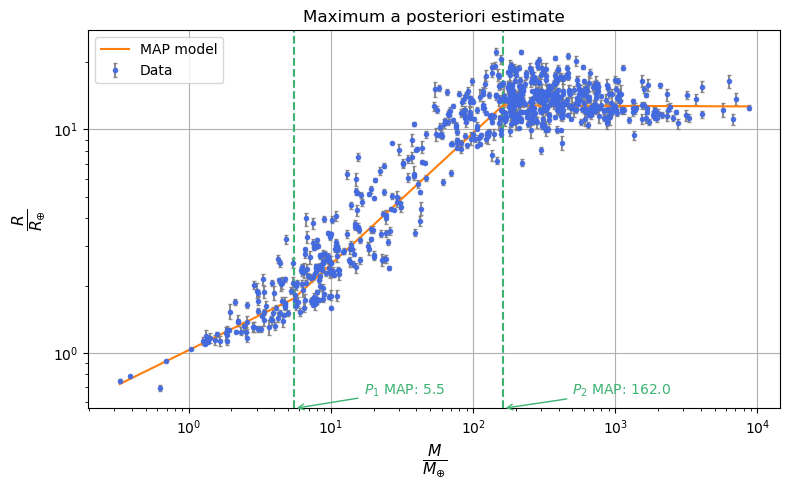

Posterior results (mean±std): 
m_1 = 0.0114 ± 0.0016
b_1 = 0.3120 ± 0.0044
b_2 = 0.2759 ± 0.0045
b_3 = -0.5905 ± 0.0023
P_1 = 5.4526 ± 0.0045
P_2 = 162.1131 ± 0.0023
mode_nd: [ 1.14485333e-02  3.14238638e-01  2.73803979e-01 -5.90726018e-01
  5.53643179e+00  1.62206360e+02]


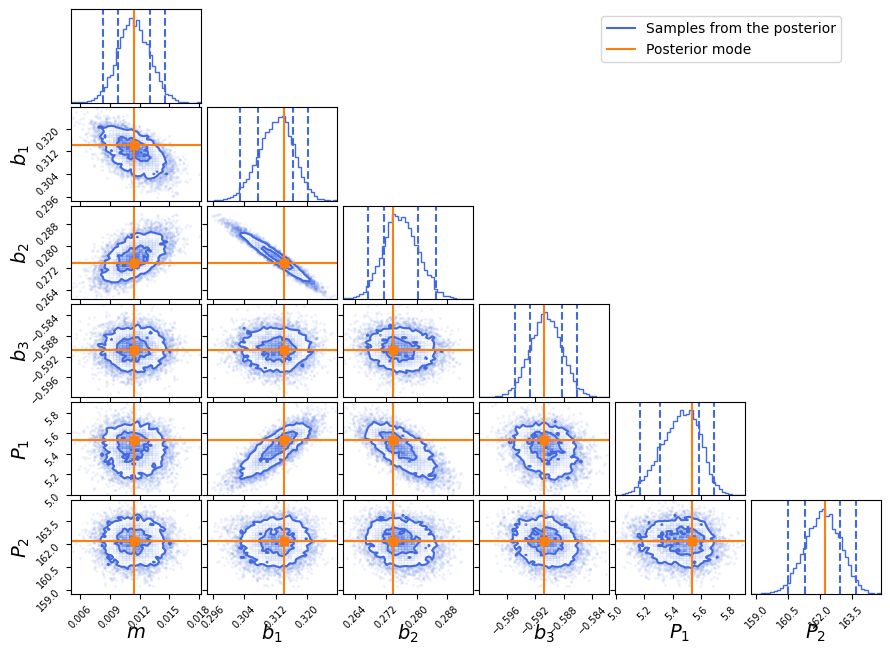

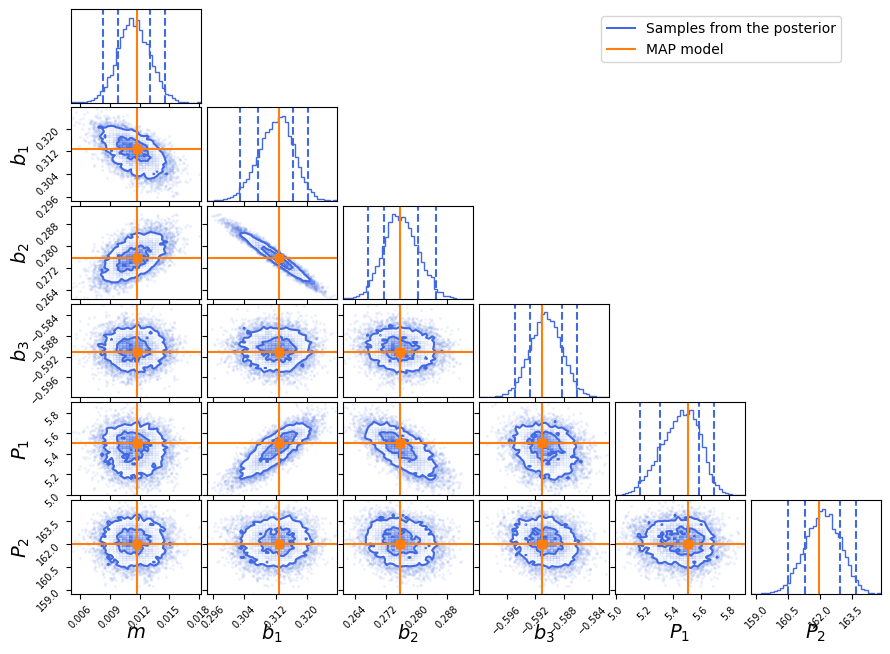

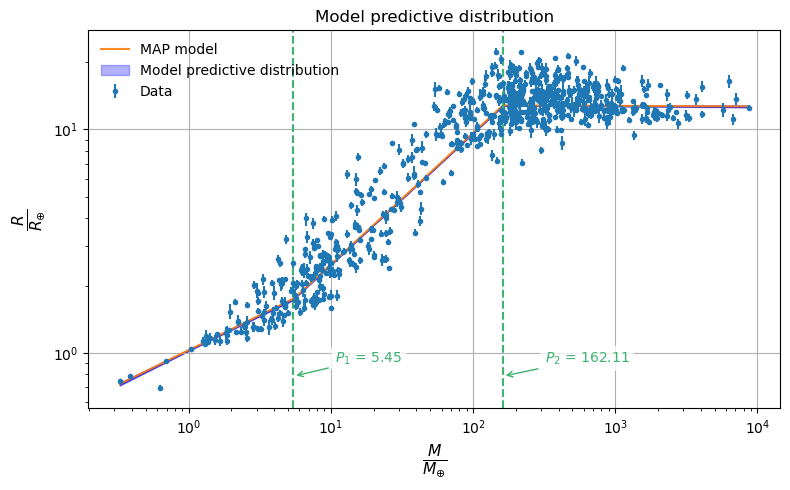

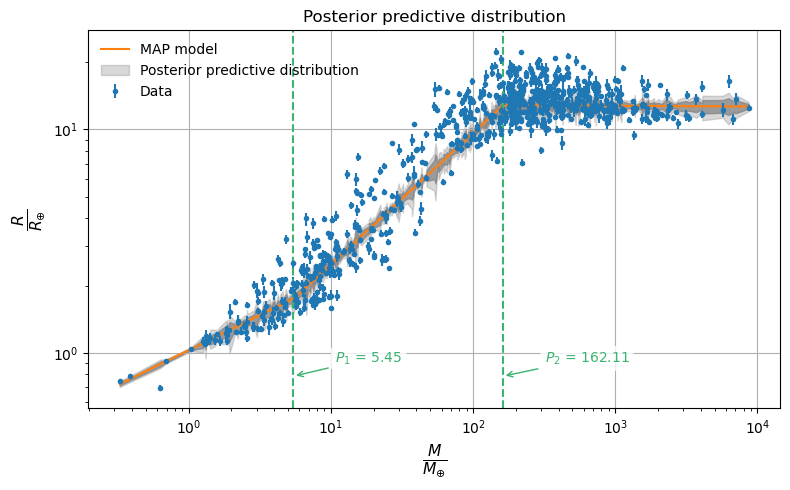

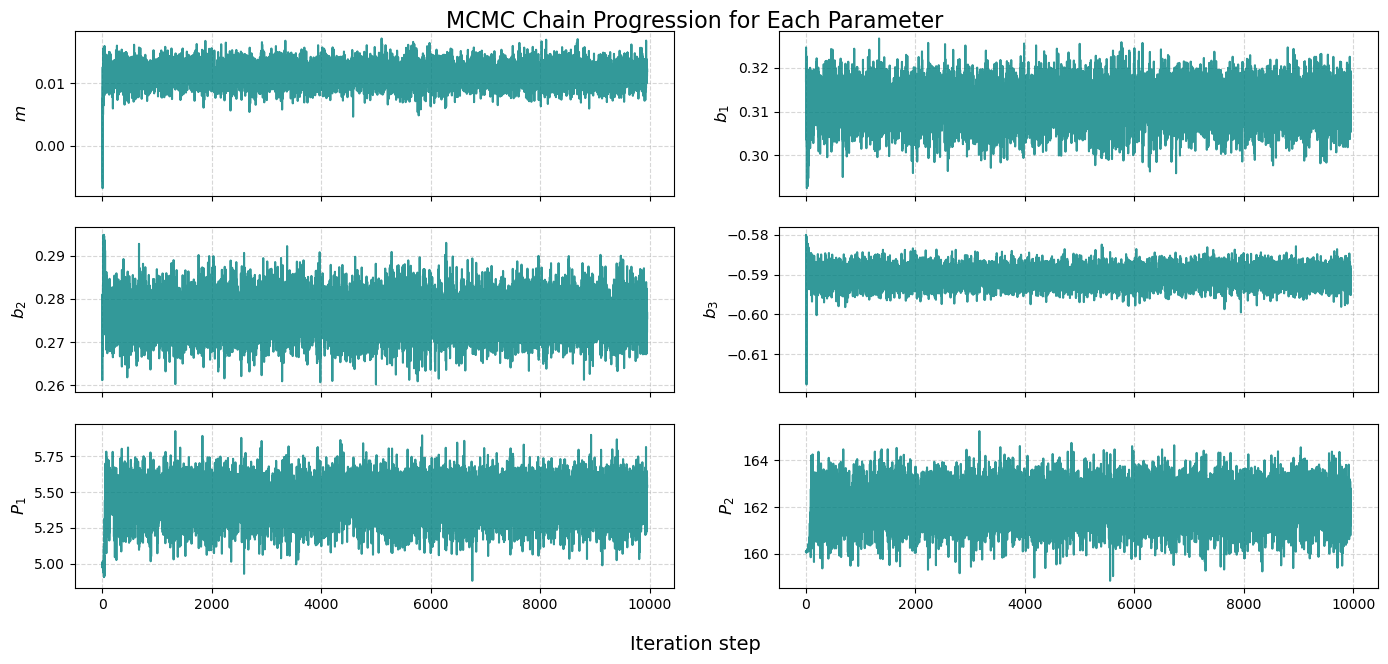

In [14]:
#Analysis for all planets with breakpoints as parameters
def log_prior_2(theta):
    m_1, b_1, b_2, b_3, P_1, P_2 =theta
    # Unnormalised uniform prior
    if -4 < m_1 < 4 and -2 < b_1 < 3 and -3 < b_2 < 3 and -3 < b_3 < 3 and 2 < P_1 < 10 and 80 < P_2 < 1000:
        return 0.0
    else:
        return -jnp.inf

theta_MAP_2_breakpoints, chain_2, ppd_2 = analyze_data_2(
    df,
    log_posterior=posterior_probability_2,
    model=model_2,
    predict=predict_2, 
    x0=(0, 0.3, 0.3, -0.5, 5, 160)
)


In [15]:
def analyze_data_3(df, log_posterior, model, predict, x0):
    
    #Evaluate the data
    m, r, m_up, m_low, r_up, r_low = jnp.array(df['m']), jnp.array(df['r']), jnp.array(df['m+']), jnp.array(df['m-']), jnp.array(df['r+']), jnp.array(df['r-'])
    m_err=jnp.concatenate((jnp.atleast_2d(m_low),jnp.atleast_2d(m_up)))
    r_err=jnp.concatenate((jnp.atleast_2d(r_low),jnp.atleast_2d(r_up)))
    sigma_y=(r_up+r_low)/2
    sigma_x=(m_up+m_low)/2
    n = len(m)
    
    theta_init = jnp.array(x0)

    #Sample the posterior with emcee
    n_param = 8    
    n_walker = 18     
    n_step = 32000   
    
    seed = 1701
    num_steps = 100
    key = jax.random.key(seed)
    for i in range(num_steps):
        key, subkey = jax.random.split(key)

    theta_init = jnp.array(x0) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, 
        ndim=n_param, 
        log_prob_fn=log_posterior,
        args=(m, sigma_y, r)
    )
    
    state = sampler.run_mcmc(theta_init, nsteps=n_step)
        
    print("Auto-correlation time:")
    m_acl, b1_acl, b2_acl, b3_acl, b4_acl, P1_acl, P2_acl, P3_acl = sampler.get_autocorr_time(quiet=True)
    
    print("m:", m_acl)
    print("b1:", b1_acl)
    print("b2:", b2_acl)
    print("b3:", b3_acl)
    print("b4:", b4_acl)
    print("P1:", P1_acl)
    print("P2:", P2_acl)
    print("P3:", P3_acl)

    acl = [m_acl, b1_acl, b2_acl, b3_acl, b4_acl, P1_acl, P2_acl, P3_acl]
        
    theta_init = jnp.array(theta_init) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    disregard = 1000
    
    chain = sampler.get_chain(discard=disregard, thin=int(max(acl)/2), flat=True)

    logs = sampler.get_log_prob(discard=disregard, thin=int(max(acl)/2), flat=True)
    a = np.argmax(logs)
    theta_MAP = chain[a,:]
    m1_MAP, b1_MAP, b2_MAP, b3_MAP, b4_MAP, P1_MAP, P2_MAP, P3_MAP = theta_MAP[:]
    
    x_plot = jnp.sort(m)
    x_plot_log = jnp.log10(x_plot)
    y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP+jnp.where(x_plot_log > jnp.log10(P2_MAP), x_plot_log - jnp.log10(P2_MAP), 0)*b3_MAP+jnp.where(x_plot_log > jnp.log10(P3_MAP), x_plot_log - jnp.log10(P3_MAP), 0)*b4_MAP)
   

    #Plot the MAP
    plot_params = {'xlabel': r"$\frac{M}{M_{\oplus}}$", 'ylabel': r"$\frac{R}{R_{\oplus}}$",
                'xscale': 'log', 'yscale': 'log'}
    fig, ax = plot_data(x=m, y=r, y_err=r_err, params=plot_params)
    # Plot vertical line at P_MAP
    vline_color = 'mediumseagreen'
    plt.axvline(P1_MAP, color=vline_color, linestyle='--')
    plt.axvline(P2_MAP, color=vline_color, linestyle='--')
    plt.axvline(P3_MAP, color=vline_color, linestyle='--')
    # Add annotations for the vertical line
    ax.annotate(rf"$P1$ MAP: {P1_MAP:.1f}", xy=(P1_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(rf"$P2$ MAP: {P2_MAP:.1f}", xy=(P2_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(rf"$P3$ MAP: {P3_MAP:.1f}", xy=(P3_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    plt.plot(x_plot, y_MAP, color='C1', label="MAP model")
    plt.title("Maximum a posteriori estimate")
    plt.legend()
    fig.tight_layout(h_pad=2.0)
    plt.savefig('three_breakpoints_MAP_model.png', dpi=300)
    plt.show()
    
    print("Posterior results (mean±std): ")
    print(f"m_1 = {jnp.mean(chain[:,0]):.4f} ± {jnp.std(chain[:,0]):.4f}")
    print(f"b_1 = {jnp.mean(chain[:,1]):.4f} ± {jnp.std(chain[:,1]):.4f}")
    print(f"b_2 = {jnp.mean(chain[:,2]):.4f} ± {jnp.std(chain[:,2]):.4f}")
    print(f"b_3 = {jnp.mean(chain[:,3]):.4f} ± {jnp.std(chain[:,3]):.4f}")
    print(f"b_4 = {jnp.mean(chain[:,4]):.4f} ± {jnp.std(chain[:,4]):.4f}")
    print(f"P_1 = {jnp.mean(chain[:,5]):.4f} ± {jnp.std(chain[:,5]):.4f}")
    print(f"P_2 = {jnp.mean(chain[:,6]):.4f} ± {jnp.std(chain[:,6]):.4f}")
    print(f"P_3 = {jnp.mean(chain[:,7]):.4f} ± {jnp.std(chain[:,7]):.4f}")
    
    
    # CORNER PLOT
    modes = []
    for i in range(chain.shape[1]):
        hist, bin_edges = np.histogram(chain[:, i], bins=40)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_bin_index = np.argmax(hist)
        mode_value = bin_centers[max_bin_index]
        modes.append(mode_value)
        
    kde = scipy.stats.gaussian_kde(chain.T)
    mode_nd = chain[np.argmax(kde(chain.T)), :]
    
    fig = plt.figure(figsize=(9,6.5))
    fig = corner.corner(chain,
                        bins=40,
                        labels=["$m$", "$b_1$", "$b_2$", "$b_3$","$b_4$", "$P_1$", "$P_2$", "$P_3$"],
                        color="royalblue",
                        truths=mode_nd,
                        truth_color="C1",
                        levels=1-np.exp(-0.5*np.array([1, 2])**2),
                        quantiles=[0.025, 0.16, 0.84, 0.975],
                        fig=fig
                       );
    
    fig.get_axes()[0].plot([], [], c="royalblue", label="Samples from the posterior")
    fig.get_axes()[0].plot([], [], c="C1", label="MAP model")
    fig.get_axes()[0].legend(loc='upper right', bbox_to_anchor=(6, 1))
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(14)  # Adjust x-axis label size
        ax.yaxis.label.set_size(14)  # Adjust y-axis label size
        ax.tick_params(axis="both", which="major", labelsize=7)  # Adjust tick label size
    #plt.savefig("one_breakpoint_corner_plot.png", dpi=300)
    plt.show()
    
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(sample, x_plot) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    
    # Get samples from the posterior predictive distribution
    posterior_predictive = np.array(
        [predict(*sample, x_plot_log, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Plot the Model predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(x_plot, y_MAP, label="MAP model", color="C1", alpha=0.9)
    ax.fill_between(x=x_plot, y1=model_quantiles[0], y2=model_quantiles[-1],
                    color="blue", alpha=0.3, label="Model predictive distribution")
    ax.fill_between(x=x_plot, y1=model_quantiles[1], y2=model_quantiles[-2],
                    color="blue", alpha=0.7)
    vline_color = 'mediumseagreen'
    P1_mean = jnp.mean(chain[:, 5])
    P2_mean = jnp.mean(chain[:, 6])
    P3_mean = jnp.mean(chain[:, 7])
    ax.axvline(P1_mean, color=vline_color, linestyle='--')
    ax.axvline(P2_mean, color=vline_color, linestyle='--')
    ax.axvline(P3_mean, color=vline_color, linestyle='--')
    y_position = ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # Adjust y-position slightly above the bottom
    ax.annotate(f"$P1$ = {P1_mean:.2f}",
                xy=(P1_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P2$ = {P2_mean:.2f}",
                xy=(P2_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P3$ = {P3_mean:.2f}",
                xy=(P3_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Model predictive distribution', color='black')
    ax.legend(frameon=False, loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    #plt.savefig('one_breakpoint_model_predictive.png', dpi=300)
    plt.show()
    plt.close()


    
    #Plot the Posterior predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[0], y2=posterior_predictive_quantiles[-1],
                 color="grey", alpha=0.3, label="Posterior predictive distribution")
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[1], y2=posterior_predictive_quantiles[-2],
                 color="grey", alpha=0.7)
    plt.plot(x_plot,y_MAP,label="MAP model", color="C1")
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size':16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Posterior predictive distribution', color='black')
    ax.grid(True)
    ax.legend(frameon=False, loc="upper left")
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('One_breakpoint_posterior_predictive.png', dpi=300)
    plt.show()

    # Generate the iteration steps
    x_iter = np.arange(start=disregard, stop= (disregard + len(chain)))
    # Create a figure with 6 subplots arranged in 2 columns
    fig, axes = plt.subplots(4, 2, figsize=(14, 7), sharex=True)
    params = ["$m$", "$b_1$", "$b_2$", "$b_3$","$b_4$", "$P_1$", "$P_2$", "$P_3$"]
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.plot(x_iter, chain[:, i], color="teal", linewidth=1.5, alpha=0.8)
        ax.set_ylabel(params[i], fontsize=12)
        ax.grid(visible=True, linestyle="--", alpha=0.5)  # Add gridlines
        ax.tick_params(axis="both", which="major", labelsize=10)

    fig.supxlabel("Iteration step", fontsize=14)
    fig.suptitle("MCMC Chain Progression for Each Parameter", fontsize=16, y=0.93)

    fig.tight_layout(h_pad=2.0, w_pad=2.0)
    plt.subplots_adjust(top=0.9)
    #plt.savefig('one_breakpoint_MCMC_chains.png', dpi=300)
    plt.show()
    
    return theta_MAP, chain, posterior_predictive

In [16]:
def model_3(theta, x):
    x_log=jnp.log10(x)
    m_1, b_1, b_2, b_3, b_4, P_1, P_2, P_3 = theta
    y=m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P_1), x_log - jnp.log10(P_1), 0)*b_2+jnp.where(x_log > jnp.log10(P_2), x_log - jnp.log10(P_2), 0)*b_3+jnp.where(x_log > jnp.log10(P_3), x_log - jnp.log10(P_3), 0)*b_4
    return 10**y


def log_likelihood_3(theta, x, sigma_y, y):
    prediction = model_3(theta, x)
    prob = -0.5 * jnp.sum((y - prediction)**2/(sigma_y**2))  
    - 1/2*jnp.sum(jnp.log(2*jnp.pi*sigma_y**2))
    if jnp.isnan(prob): return -jnp.inf
    return (prob)

def posterior_probability_3(theta, x, sigma_y, y):
    return (
        log_likelihood_3(theta, x, sigma_y, y)
        + log_prior_3(theta))
    
def predict_3(m_1, b_1, b_2, b_3, b_4, P_1, P_2, P_3, x_log, sigma_y):
    mi = 10**(m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P_1), x_log - jnp.log10(P_1), 0)*b_2+jnp.where(x_log > jnp.log10(P_2), x_log - jnp.log10(P_2), 0)*b_3+jnp.where(x_log > jnp.log10(P_3), x_log - jnp.log10(P_3), 0)*b_4)
    return np.random.normal(loc=mi, scale=sigma_y)

Auto-correlation time:
m: 82.4777263310874
b1: 105.67633492837369
b2: 121.86858834828395
b3: 124.58279180186614
b4: 109.04616340326086
P1: 140.33210198209537
P2: 148.17443476051864
P3: 168.7436802979117


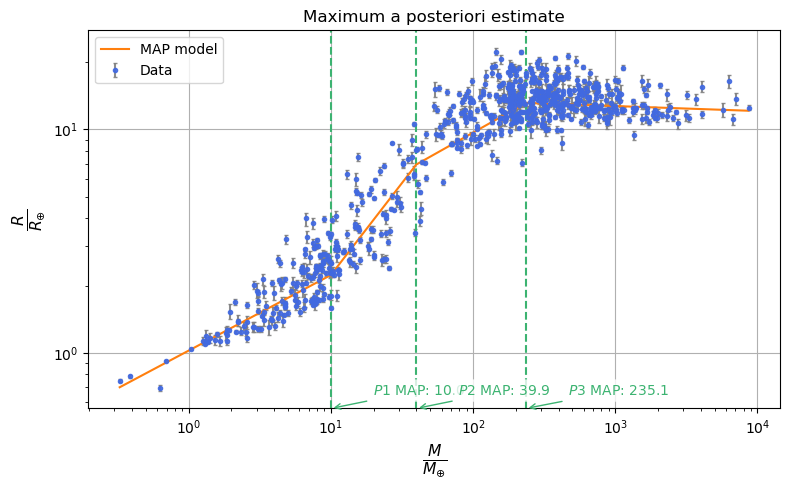

Posterior results (mean±std): 
m_1 = 0.0103 ± 0.0016
b_1 = 0.3379 ± 0.0021
b_2 = 0.4875 ± 0.0046
b_3 = -0.4690 ± 0.0058
b_4 = -0.3808 ± 0.0037
P_1 = 10.0407 ± 0.0495
P_2 = 39.8960 ± 0.0576
P_3 = 237.5985 ± 3.2841


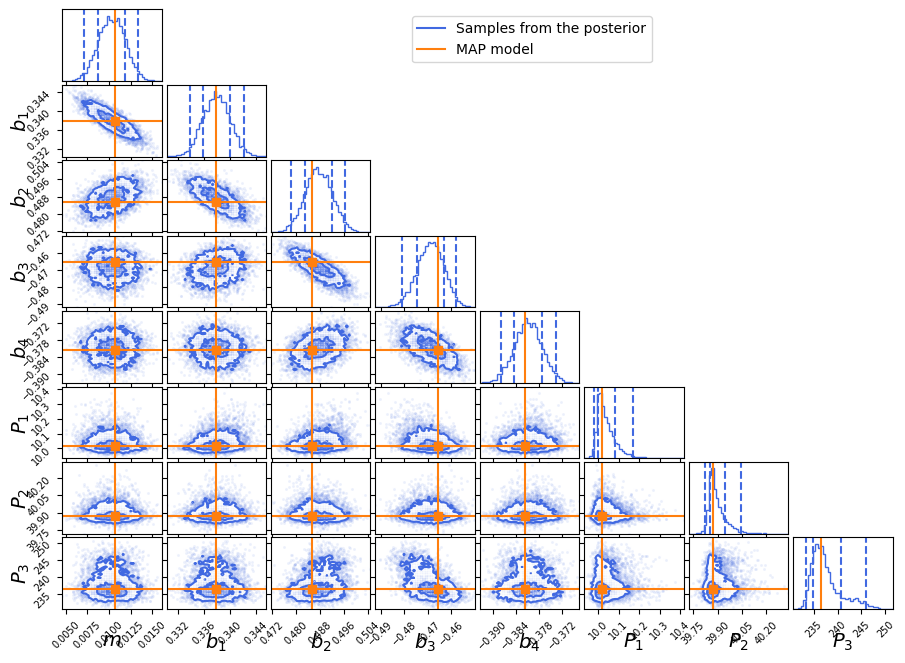

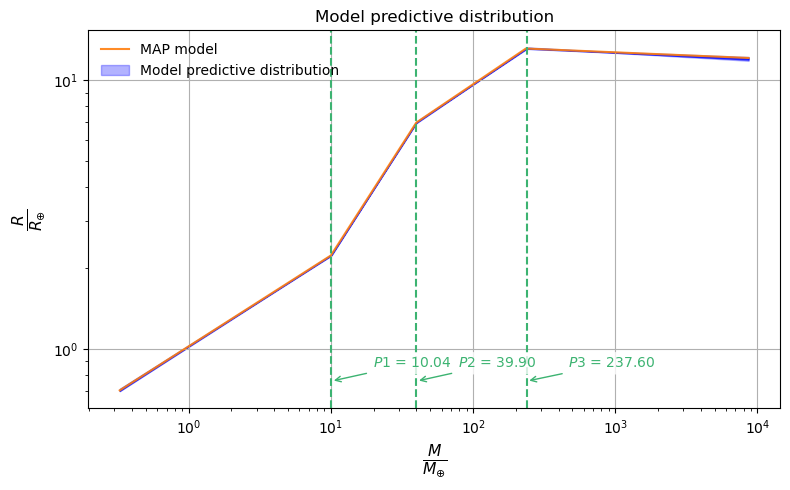

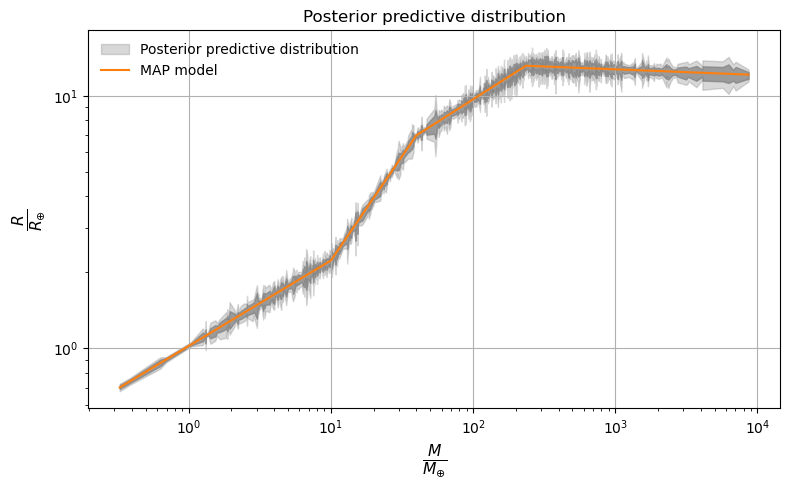

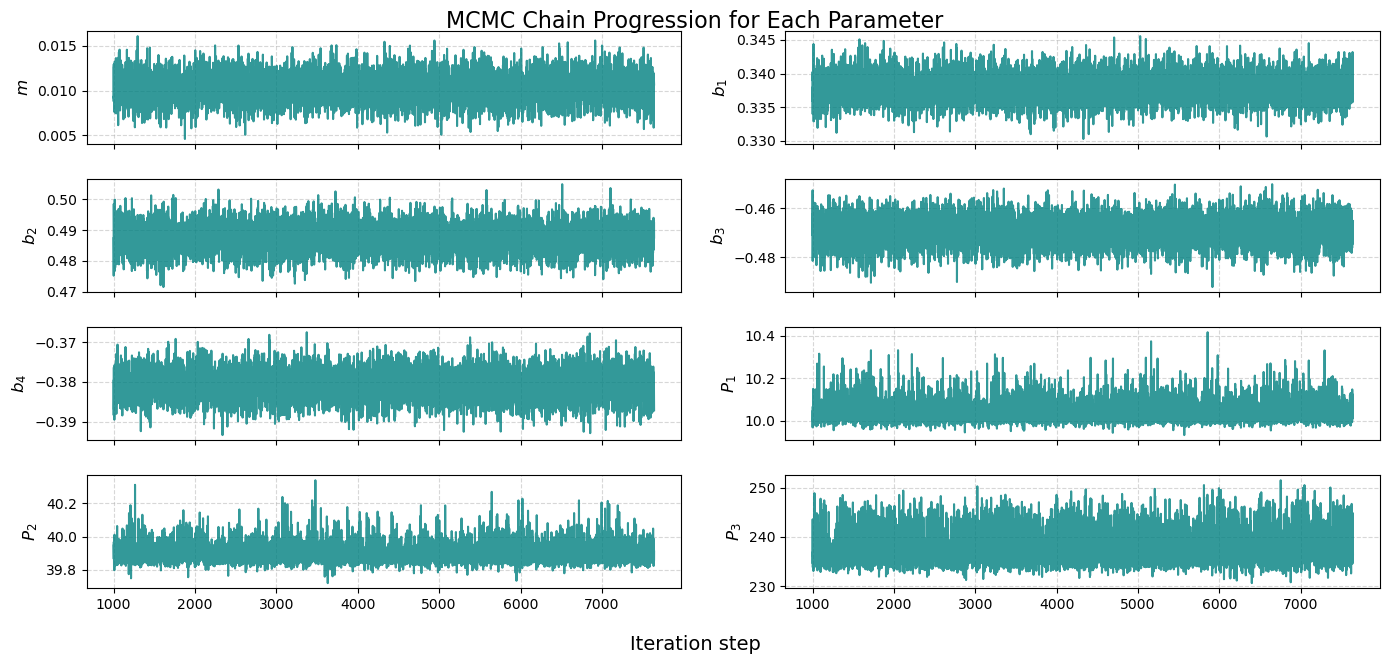

In [17]:
def log_prior_3(theta):
    m_1, b_1, b_2, b_3, b_4, P_1, P_2, P_3 = theta
    # Unnormalised uniform prior
    if -4 < m_1 < 4 and -2 < b_1 < 3 and -3 < b_2 < 3 and -3 < b_3 < 3 and -3 < b_4 < 3 and 1 < P_1 < 100 and 5 < P_2 < 300 and 100 < P_3 < 500:
        return 0.0
    else:
        return -jnp.inf

theta_MAP_3_breakpoints, chain_3, ppd_3 = analyze_data_3(
    df,
    log_posterior=posterior_probability_3,
    model=model_3,
    predict=predict_3, 
    x0=(0,0.35,0.5,-0.4,-0.4,10,40,240)
)

In [18]:
def analyze_data_4(df, log_posterior, model, predict, x0):
    
    #Evaluate the data
    m, r, m_up, m_low, r_up, r_low = jnp.array(df['m']), jnp.array(df['r']), jnp.array(df['m+']), jnp.array(df['m-']), jnp.array(df['r+']), jnp.array(df['r-'])
    m_err=jnp.concatenate((jnp.atleast_2d(m_low),jnp.atleast_2d(m_up)))
    r_err=jnp.concatenate((jnp.atleast_2d(r_low),jnp.atleast_2d(r_up)))
    sigma_y=(r_up+r_low)/2
    sigma_x=(m_up+m_low)/2
    n = len(m)
    
    theta_init = jnp.array(x0)

    #Sample the posterior with emcee
    n_param = 10    
    n_walker = 22     
    n_step = 32000   
    
    seed = 1701
    num_steps = 100
    key = jax.random.key(seed)
    for i in range(num_steps):
        key, subkey = jax.random.split(key)

    theta_init = jnp.array(x0) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, 
        ndim=n_param, 
        log_prob_fn=log_posterior,
        args=(m, sigma_y, r)
    )
    
    state = sampler.run_mcmc(theta_init, nsteps=n_step)
        
    print("Auto-correlation time:")
    m_acl, b1_acl, b2_acl, b3_acl, b4_acl, b5_acl, P1_acl, P2_acl, P3_acl, P4_acl = sampler.get_autocorr_time(quiet=True)
    
    print("m:", m_acl)
    print("b1:", b1_acl)
    print("b2:", b2_acl)
    print("b3:", b3_acl)
    print("b4:", b4_acl)
    print("b5:", b5_acl)
    print("P1:", P1_acl)
    print("P2:", P2_acl)
    print("P3:", P3_acl)
    print("P4:", P4_acl)

    acl = [m_acl, b1_acl, b2_acl, b3_acl, b4_acl, b5_acl, P1_acl, P2_acl, P3_acl, P4_acl]
        
    theta_init = jnp.array(theta_init) + 0.1*jax.random.normal(key=subkey,shape=(n_walker, n_param))

    disregard = 1000
    
    chain = sampler.get_chain(discard=disregard, thin=int(max(acl)/2), flat=True)

    logs = sampler.get_log_prob(discard=disregard, thin=int(max(acl)/2), flat=True)
    a = np.argmax(logs)
    theta_MAP = chain[a,:]
    m1_MAP, b1_MAP, b2_MAP, b3_MAP, b4_MAP, b5_MAP, P1_MAP, P2_MAP, P3_MAP, P4_MAP = theta_MAP[:]
    
    x_plot = jnp.sort(m)
    x_plot_log = jnp.log10(x_plot)
    y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP+jnp.where(x_plot_log > jnp.log10(P2_MAP), x_plot_log - jnp.log10(P2_MAP), 0)*b3_MAP+jnp.where(x_plot_log > jnp.log10(P3_MAP), x_plot_log - jnp.log10(P3_MAP), 0)*b4_MAP+jnp.where(x_plot_log > jnp.log10(P4_MAP), x_plot_log - jnp.log10(P4_MAP), 0)*b5_MAP)
   

    #Plot the MAP
    plot_params = {'xlabel': r"$\frac{M}{M_{\oplus}}$", 'ylabel': r"$\frac{R}{R_{\oplus}}$",
                'xscale': 'log', 'yscale': 'log'}
    fig, ax = plot_data(x=m, y=r, y_err=r_err, params=plot_params)
    # Plot vertical line at P_MAP
    vline_color = 'mediumseagreen'
    plt.axvline(P1_MAP, color=vline_color, linestyle='--')
    plt.axvline(P2_MAP, color=vline_color, linestyle='--')
    plt.axvline(P3_MAP, color=vline_color, linestyle='--')
    plt.axvline(P4_MAP, color=vline_color, linestyle='--')
    # Add annotations for the vertical line
    ax.annotate(rf"$P1$ MAP: {P1_MAP:.1f}", xy=(P1_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(rf"$P2$ MAP: {P2_MAP:.1f}", xy=(P2_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(rf"$P3$ MAP: {P3_MAP:.1f}", xy=(P3_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(rf"$P4$ MAP: {P4_MAP:.1f}", xy=(P4_MAP, ax.get_ylim()[0]), 
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    plt.plot(x_plot, y_MAP, color='C1', label="MAP model")
    plt.title("Maximum a posteriori estimate")
    plt.legend()
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('three_breakpoints_MAP_model.png', dpi=300)
    plt.show()
    
    print("Posterior results (mean±std): ")
    print(f"m_1 = {jnp.mean(chain[:,0]):.4f} ± {jnp.std(chain[:,0]):.4f}")
    print(f"b_1 = {jnp.mean(chain[:,1]):.4f} ± {jnp.std(chain[:,1]):.4f}")
    print(f"b_2 = {jnp.mean(chain[:,2]):.4f} ± {jnp.std(chain[:,2]):.4f}")
    print(f"b_3 = {jnp.mean(chain[:,3]):.4f} ± {jnp.std(chain[:,3]):.4f}")
    print(f"b_4 = {jnp.mean(chain[:,4]):.4f} ± {jnp.std(chain[:,4]):.4f}")
    print(f"b_5 = {jnp.mean(chain[:,5]):.4f} ± {jnp.std(chain[:,5]):.4f}")
    print(f"P_1 = {jnp.mean(chain[:,6]):.4f} ± {jnp.std(chain[:,6]):.4f}")
    print(f"P_2 = {jnp.mean(chain[:,7]):.4f} ± {jnp.std(chain[:,7]):.4f}")
    print(f"P_3 = {jnp.mean(chain[:,8]):.4f} ± {jnp.std(chain[:,8]):.4f}")
    print(f"P_4 = {jnp.mean(chain[:,9]):.4f} ± {jnp.std(chain[:,9]):.4f}")
    
    
    # CORNER PLOT
    modes = []
    for i in range(chain.shape[1]):
        hist, bin_edges = np.histogram(chain[:, i], bins=40)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_bin_index = np.argmax(hist)
        mode_value = bin_centers[max_bin_index]
        modes.append(mode_value)
        
    kde = scipy.stats.gaussian_kde(chain.T)
    mode_nd = chain[np.argmax(kde(chain.T)), :]
    
    fig = plt.figure(figsize=(9,6.5))
    fig = corner.corner(chain,
                        bins=40,
                        labels=["$m$", "$b_1$", "$b_2$", "$b_3$","$b_4$", "$b_5$", "$P_1$", "$P_2$", "$P_3$", "$P_4$"],
                        color="royalblue",
                        truths=mode_nd,
                        truth_color="C1",
                        levels=1-np.exp(-0.5*np.array([1, 2])**2),
                        quantiles=[0.025, 0.16, 0.84, 0.975],
                        fig=fig
                       );
    
    fig.get_axes()[0].plot([], [], c="royalblue", label="Samples from the posterior")
    fig.get_axes()[0].plot([], [], c="C1", label="MAP model")
    fig.get_axes()[0].legend(loc='upper right', bbox_to_anchor=(6, 1))
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(14)  # Adjust x-axis label size
        ax.yaxis.label.set_size(14)  # Adjust y-axis label size
        ax.tick_params(axis="both", which="major", labelsize=7)  # Adjust tick label size
    #plt.savefig("one_breakpoint_corner_plot.png", dpi=300)
    plt.show()
    
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(sample, x_plot) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    
    # Get samples from the posterior predictive distribution
    posterior_predictive = np.array(
        [predict(*sample, x_plot_log, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    # Plot the Model predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(x_plot, y_MAP, label="MAP model", color="C1", alpha=0.9)
    ax.fill_between(x=x_plot, y1=model_quantiles[0], y2=model_quantiles[-1],
                    color="blue", alpha=0.3, label="Model predictive distribution")
    ax.fill_between(x=x_plot, y1=model_quantiles[1], y2=model_quantiles[-2],
                    color="blue", alpha=0.7)
    vline_color = 'mediumseagreen'
    P1_mean = jnp.mean(chain[:, 6])
    P2_mean = jnp.mean(chain[:, 7])
    P3_mean = jnp.mean(chain[:, 8])
    P4_mean = jnp.mean(chain[:, 9])
    ax.axvline(P1_mean, color=vline_color, linestyle='--')
    ax.axvline(P2_mean, color=vline_color, linestyle='--')
    ax.axvline(P3_mean, color=vline_color, linestyle='--')
    ax.axvline(P4_mean, color=vline_color, linestyle='--')
    y_position = ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # Adjust y-position slightly above the bottom
    ax.annotate(f"$P1$ = {P1_mean:.2f}",
                xy=(P1_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P2$ = {P2_mean:.2f}",
                xy=(P2_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P3$ = {P3_mean:.2f}",
                xy=(P3_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.annotate(f"$P4$ = {P4_mean:.2f}",
                xy=(P4_mean, y_position),
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=vline_color, lw=1),
                fontsize=10, color=vline_color,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8))
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Model predictive distribution', color='black')
    ax.legend(frameon=False, loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    #plt.savefig('one_breakpoint_model_predictive.png', dpi=300)
    plt.show()
    plt.close()


    
    #Plot the Posterior predictive distribution
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[0], y2=posterior_predictive_quantiles[-1],
                 color="grey", alpha=0.3, label="Posterior predictive distribution")
    plt.fill_between(x=x_plot, y1=posterior_predictive_quantiles[1], y2=posterior_predictive_quantiles[-2],
                 color="grey", alpha=0.7)
    plt.plot(x_plot,y_MAP,label="MAP model", color="C1")
    ax.set_xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontdict={'size':16})
    ax.set_ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontdict={'size': 16})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Posterior predictive distribution', color='black')
    ax.grid(True)
    ax.legend(frameon=False, loc="upper left")
    fig.tight_layout(h_pad=2.0)
    #plt.savefig('One_breakpoint_posterior_predictive.png', dpi=300)
    plt.show()

    # Generate the iteration steps
    x_iter = np.arange(start=disregard, stop= (disregard + len(chain)))
    # Create a figure with 10 subplots arranged in 2 columns
    fig, axes = plt.subplots(5, 2, figsize=(14, 7), sharex=True)
    params = ["$m$", "$b_1$", "$b_2$", "$b_3$","$b_4$","$b_5$", "$P_1$", "$P_2$", "$P_3$","$P_4$"]
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.plot(x_iter, chain[:, i], color="teal", linewidth=1.5, alpha=0.8)
        ax.set_ylabel(params[i], fontsize=12)
        ax.grid(visible=True, linestyle="--", alpha=0.5)  # Add gridlines
        ax.tick_params(axis="both", which="major", labelsize=10)

    fig.supxlabel("Iteration step", fontsize=14)
    fig.suptitle("MCMC Chain Progression for Each Parameter", fontsize=16, y=0.93)

    fig.tight_layout(h_pad=2.0, w_pad=2.0)
    plt.subplots_adjust(top=0.9)
    #plt.savefig('one_breakpoint_MCMC_chains.png', dpi=300)
    plt.show()
    
    return theta_MAP, chain, posterior_predictive

In [19]:
def model_4(theta, x):
    x_log=jnp.log10(x)
    m_1, b_1, b_2, b_3, b_4, b_5, P_1, P_2, P_3, P_4 = theta
    y=m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P_1), x_log - jnp.log10(P_1), 0)*b_2+jnp.where(x_log > jnp.log10(P_2), x_log - jnp.log10(P_2), 0)*b_3+jnp.where(x_log > jnp.log10(P_3), x_log - jnp.log10(P_3), 0)*b_4+jnp.where(x_log > jnp.log10(P_4), x_log - jnp.log10(P_4), 0)*b_5
    return 10**y


def log_likelihood_4(theta, x, sigma_y, y):
    prediction = model_4(theta, x)
    prob = -0.5 * jnp.sum((y - prediction)**2/(sigma_y**2))  
    - 1/2*jnp.sum(jnp.log(2*jnp.pi*sigma_y**2))
    if jnp.isnan(prob): return -jnp.inf
    return (prob)

def posterior_probability_4(theta, x, sigma_y, y):
    return (
        log_likelihood_4(theta, x, sigma_y, y)
        + log_prior_4(theta))
    
def predict_4(m_1, b_1, b_2, b_3, b_4, b_5, P_1, P_2, P_3, P_4, x_log, sigma_y):
    mi = 10**(m_1+x_log*b_1+jnp.where(x_log > jnp.log10(P_1), x_log - jnp.log10(P_1), 0)*b_2+jnp.where(x_log > jnp.log10(P_2), x_log - jnp.log10(P_2), 0)*b_3+jnp.where(x_log > jnp.log10(P_3), x_log - jnp.log10(P_3), 0)*b_4+jnp.where(x_log > jnp.log10(P_4), x_log - jnp.log10(P_4), 0)*b_5)
    return np.random.normal(loc=mi, scale=sigma_y)

Auto-correlation time:


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 640;
tau: [154.82696698 158.86890821 253.78196561 489.68073316 642.23942126
 560.055263   258.50703958 256.64229051 769.29608912 453.18412946]


m: 154.82696698094628
b1: 158.86890820964794
b2: 253.7819656059246
b3: 489.68073315680317
b4: 642.2394212585306
b5: 560.0552630028521
P1: 258.5070395842732
P2: 256.6422905101541
P3: 769.2960891177287
P4: 453.1841294568272


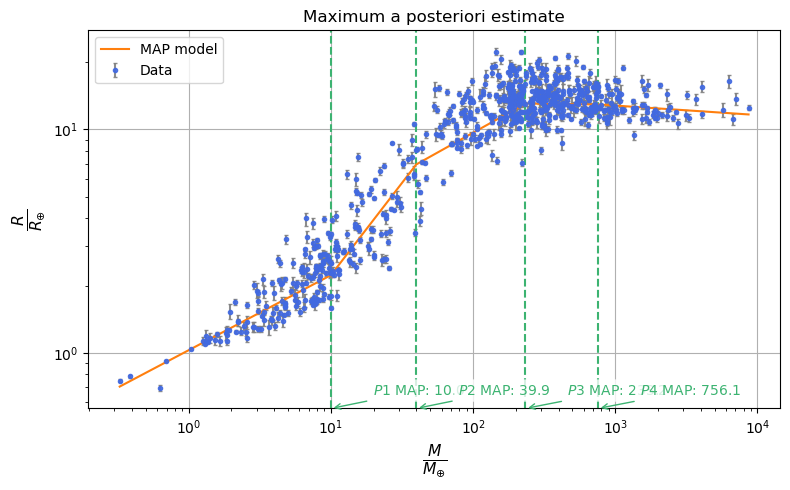

Posterior results (mean±std): 
m_1 = 0.0103 ± 0.0016
b_1 = 0.3380 ± 0.0021
b_2 = 0.4870 ± 0.0048
b_3 = -0.4680 ± 0.0064
b_4 = -0.3631 ± 0.0086
b_5 = -0.0374 ± 0.0127
P_1 = 10.0401 ± 0.0482
P_2 = 39.8937 ± 0.0563
P_3 = 231.3377 ± 5.9258
P_4 = 760.3092 ± 141.0667


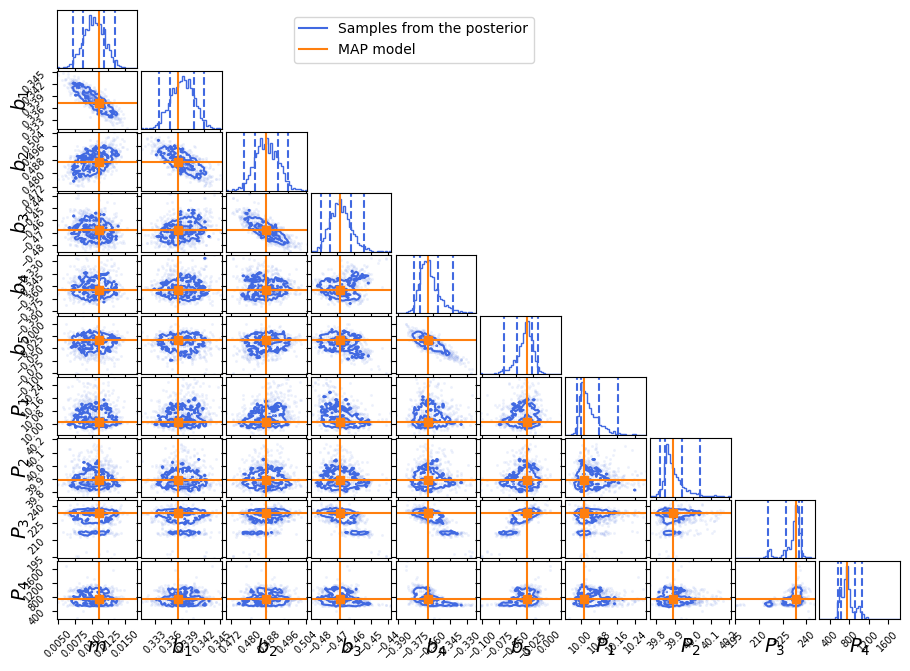

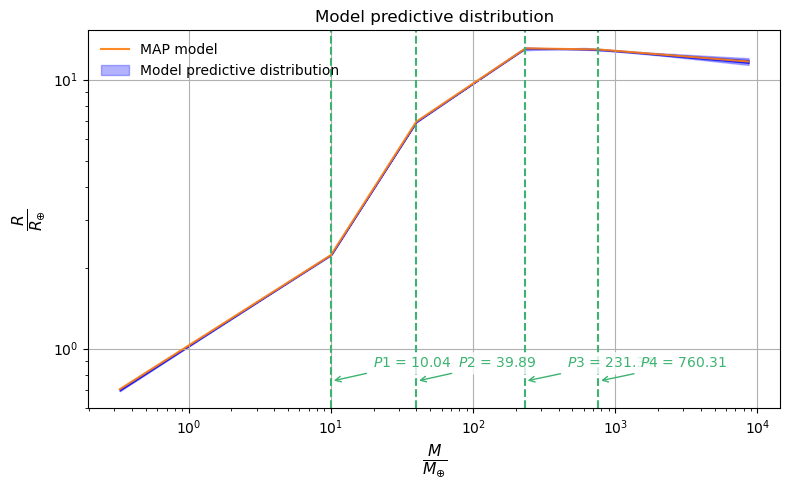

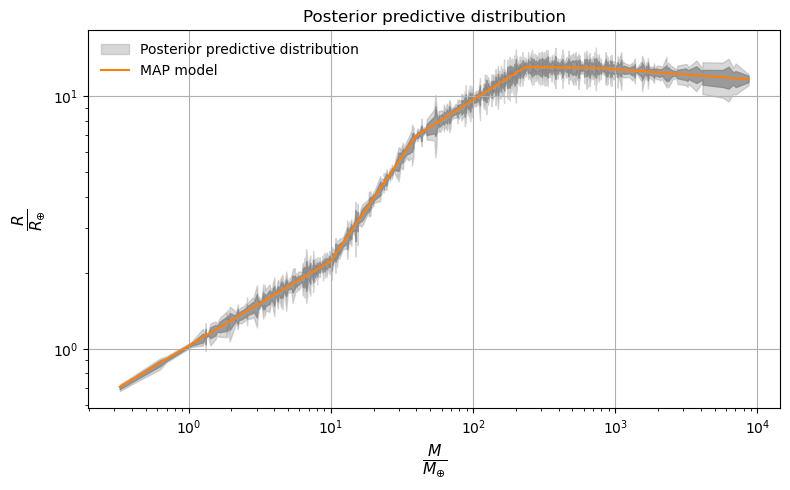

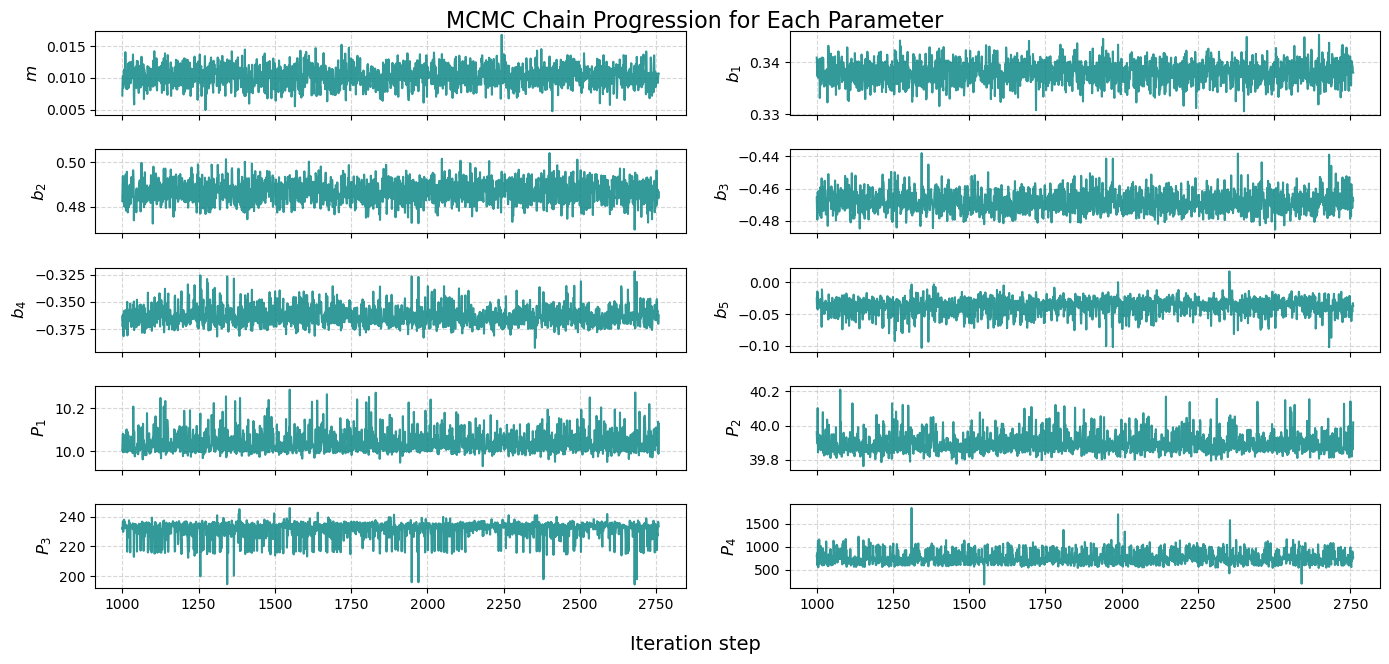

In [25]:
#Analysis for all planets with four breakpoints

def log_prior_4(theta):
    m_1, b_1, b_2, b_3, b_4, b_5, P_1, P_2, P_3, P_4 = theta
    # Unnormalised uniform prior
    if -4 < m_1 < 4 and -2 < b_1 < 3 and -3 < b_2 < 3 and -3 < b_3 < 3 and -3 < b_4 < 3 and -3 < b_5 < 3 and 1 < P_1 < 100 and 5 < P_2 < 100 and 50 < P_3 < 500 and 100 < P_4 < 2000:
        return 0.0
    else:
        return -jnp.inf

theta_MAP_4_breakpoints, chain_4, ppd_4 = analyze_data_4(
    df,
    log_posterior=posterior_probability_4,
    model=model_4,
    predict=predict_4, 
    x0=(0,0.35,0.5,-0.45,-0.35,0,10,40,235,750)
)

In [26]:
# Extract data from the DataFrame
m, r, r_up, r_low = jnp.array(df['m']), jnp.array(df['r']), jnp.array(df['r+']), jnp.array(df['r-'])
sigma_y = (r_up + r_low) / 2

In [27]:
x_plot = jnp.sort(m)
x_plot_log = jnp.log10(x_plot)
n = len(m)

m1_MAP, b1_MAP = theta_MAP_0_breakpoints[:]
y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP)
k = 2
BIC = n*np.log(1/n*np.sum((r-y_MAP)**2))+k*np.log(n)
print("BIC with zero breakpoints:", BIC)

m1_MAP, b1_MAP, b2_MAP, P1_MAP = theta_MAP_1_breakpoint[:]
y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP)
k = 4
BIC = n*np.log(1/n*np.sum((r-y_MAP)**2))+k*np.log(n)
print("BIC with one breakpoint: ", BIC)

m1_MAP, b1_MAP, b2_MAP, b3_MAP, P1_MAP, P2_MAP = theta_MAP_2_breakpoints[:]
y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP+jnp.where(x_plot_log > jnp.log10(P2_MAP), x_plot_log - jnp.log10(P2_MAP), 0)*b3_MAP)
k=6
BIC = n*np.log(1/n*np.sum((r-y_MAP)**2))+k*np.log(n)
print("BIC with two breakpoints: ", BIC)

m1_MAP, b1_MAP, b2_MAP, b3_MAP, b4_MAP, P1_MAP, P2_MAP, P3_MAP = theta_MAP_3_breakpoints[:]
y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP+jnp.where(x_plot_log > jnp.log10(P2_MAP), x_plot_log - jnp.log10(P2_MAP), 0)*b3_MAP+jnp.where(x_plot_log > jnp.log10(P3_MAP), x_plot_log - jnp.log10(P3_MAP), 0)*b4_MAP)
k = 8
BIC = n*np.log(1/n*np.sum((r-y_MAP)**2))+k*np.log(n)
print("BIC with three breakpoints: ", BIC)

m1_MAP, b1_MAP, b2_MAP, b3_MAP, b4_MAP, b5_MAP, P1_MAP, P2_MAP, P3_MAP, P4_MAP = theta_MAP_4_breakpoints[:]
y_MAP = 10**(m1_MAP+x_plot_log*b1_MAP+jnp.where(x_plot_log > jnp.log10(P1_MAP), x_plot_log - jnp.log10(P1_MAP), 0)*b2_MAP+jnp.where(x_plot_log > jnp.log10(P2_MAP), x_plot_log - jnp.log10(P2_MAP), 0)*b3_MAP+jnp.where(x_plot_log > jnp.log10(P3_MAP), x_plot_log - jnp.log10(P3_MAP), 0)*b4_MAP+jnp.where(x_plot_log > jnp.log10(P4_MAP), x_plot_log - jnp.log10(P4_MAP), 0)*b5_MAP)
k = 10
BIC = n*np.log(1/n*np.sum((r-y_MAP)**2))+k*np.log(n)
print("BIC with four breakpoints: ", BIC)


BIC with zero breakpoints: 2269.987143039368
BIC with one breakpoint:  1339.0345234864208
BIC with two breakpoints:  1326.6225235452134
BIC with three breakpoints:  1337.8607063280049
BIC with four breakpoints:  1353.0369791967798
